<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=205456323" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
os.environ['PYTHON_PATH'] = "/kaggle/working/"

In [3]:
import torch
import os

# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def D_train(x, G, D, D_optimizer, criterion):
    #======================= Train the discriminator =======================#
    D.zero_grad()

    # Train discriminator on real data
    x_real = x.to(device)
    y_real = torch.ones(x_real.shape[0], 1, device=device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake data
    z = torch.randn(x_real.shape[0], 100, device=device)  # Latent vector
    x_fake = G(z)
    y_fake = torch.zeros(x_real.shape[0], 1, device=device)

    D_output = D(x_fake)

    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Gradient backpropagation & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return D_loss.item(), D_real_score, D_fake_score  # Return scores for analysis


def G_train(x, G, D, G_optimizer, criterion):
    #======================= Train the generator =======================#
    G.zero_grad()

    z = torch.randn(x.shape[0], 100, device=device)  # Latent vector
    y = torch.ones(z.shape[0], 1, device=device)  # Target for generator

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backpropagation & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.item(), D_output  # Return D_output for analysis


def save_models(G, D, folder):
    os.makedirs(folder, exist_ok=True)  # Ensure the folder exists
    torch.save(G.state_dict(), os.path.join(folder, 'G.pth'))
    torch.save(D.state_dict(), os.path.join(folder, 'D.pth'))


def load_model(model, folder, is_generator=True):
    model_type = 'G' if is_generator else 'D'
    ckpt = torch.load(os.path.join(folder, f'{model_type}.pth'), map_location=device)  # Load model to the correct device
    model.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()})
    return model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(SanDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
        # Self-attention inspired parameters
        self.attention_weights = nn.Parameter(torch.randn(1, self.fc3.out_features))

    def forward(self, x):
        # Extract features through fully connected layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        
        # Attention-inspired feature scaling
        x_norm = F.normalize(x, dim=1)  # Normalize features for stable scaling
        scale = torch.norm(self.attention_weights, dim=1, keepdim=True)  # Calculate the scale
        x = x_norm * scale  # Scale the features
        
        # Final output
        x = torch.sigmoid(self.fc4(x))
        return x

In [5]:
import torch 
import torchvision
import os
import argparse

In [6]:
args = argparse.Namespace(batch_size=20)  # Set default value

print('Model Loading...')
# Model Pipeline
mnist_dim = 784

model = Generator(g_output_dim = mnist_dim).cuda()
model = load_model(model, '/kaggle/input/g/pytorch/v2/1/')
model = torch.nn.DataParallel(model).cuda()
model.eval()

print('Model loaded.')


print('Start Generating')
os.makedirs('samples', exist_ok=True)

image_paths = []

n_samples = 0
with torch.no_grad():
    while n_samples<10000:
        z = torch.randn(args.batch_size, 100).cuda()
        x = model(z)
        x = x.reshape(args.batch_size, 28, 28)
        for k in range(x.shape[0]):
            if n_samples<10000:
                image_path = os.path.join('samples', f'{n_samples}.png')
                torchvision.utils.save_image(x[k:k+1], image_path)         
                image_paths.append(image_path)  # Store image path
                n_samples += 1

Model Loading...


/tmp/ipykernel_30/2917978683.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(folder, f'{model_type}.pth'), map_location=device)  # Load m

Model loaded.
Start Generating


In [7]:
from IPython.display import display, Image

for img_path in image_paths[:50]:  # Slice to get only the first 10 images
    display(Image(filename=img_path))

In [8]:
torch.backends.cudnn.benchmark = True

cuda
Dataset loading...
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 12339265.45it/s]


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 320626.81it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3175930.97it/s]


Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2929949.06it/s]


Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Dataset Loaded.
Model Loading...
Model loaded.
Start Training:


  0%|          | 0/400 [00:00<?, ?it/s]

1


  0%|          | 1/400 [00:05<39:11,  5.89s/it]

Epoch [1/400], D Loss: 1.1304, G Loss: 0.6654
2


  0%|          | 2/400 [00:11<38:06,  5.75s/it]

Epoch [2/400], D Loss: 0.6899, G Loss: 1.2703
3


  1%|          | 3/400 [00:17<39:39,  5.99s/it]

Epoch [3/400], D Loss: 0.3258, G Loss: 2.4070
4


  1%|          | 4/400 [00:23<39:29,  5.98s/it]

Epoch [4/400], D Loss: 1.0096, G Loss: 1.6322
5


  1%|▏         | 5/400 [00:30<40:23,  6.13s/it]

Epoch [5/400], D Loss: 1.2297, G Loss: 1.9589
6


  2%|▏         | 6/400 [00:36<40:52,  6.22s/it]

Epoch [6/400], D Loss: 1.0967, G Loss: 1.8953
7


  2%|▏         | 7/400 [00:42<39:20,  6.01s/it]

Epoch [7/400], D Loss: 0.9541, G Loss: 2.1112
8


  2%|▏         | 8/400 [00:48<39:50,  6.10s/it]

Epoch [8/400], D Loss: 0.7746, G Loss: 2.8194
9


  2%|▏         | 9/400 [00:54<39:22,  6.04s/it]

Epoch [9/400], D Loss: 1.3862, G Loss: 2.8451
10
Epoch [10/400], D Loss: 0.3161, G Loss: 3.6728


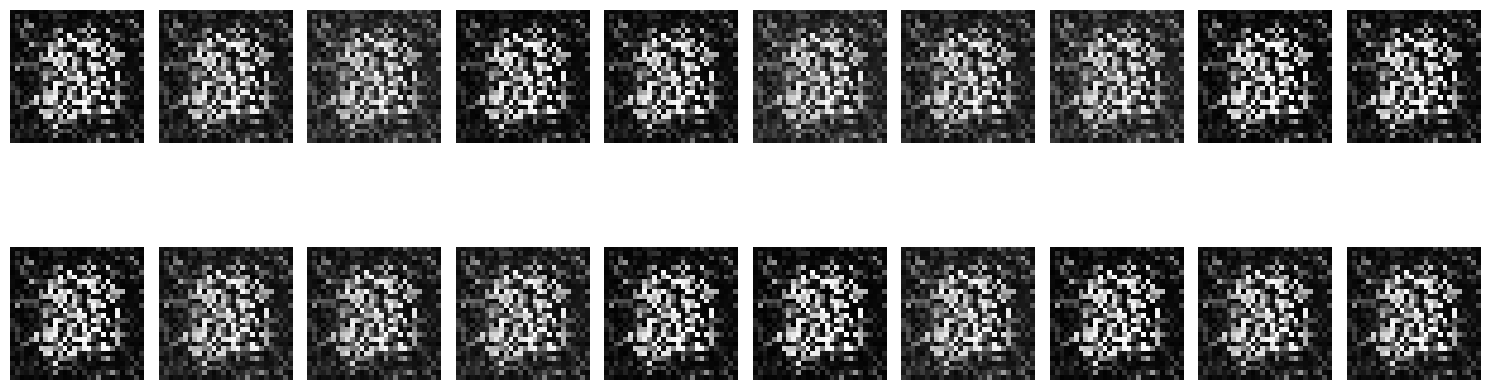

  2%|▎         | 10/400 [01:01<40:34,  6.24s/it]

11


  3%|▎         | 11/400 [01:07<40:02,  6.18s/it]

Epoch [11/400], D Loss: 0.8065, G Loss: 3.3599
12


  3%|▎         | 12/400 [01:12<39:17,  6.08s/it]

Epoch [12/400], D Loss: 0.9381, G Loss: 3.2380
13


  3%|▎         | 13/400 [01:19<39:14,  6.08s/it]

Epoch [13/400], D Loss: 0.3388, G Loss: 3.8757
14


  4%|▎         | 14/400 [01:25<40:14,  6.26s/it]

Epoch [14/400], D Loss: 0.4181, G Loss: 3.4533
15


  4%|▍         | 15/400 [01:31<39:35,  6.17s/it]

Epoch [15/400], D Loss: 1.0098, G Loss: 1.5410
16


  4%|▍         | 16/400 [01:37<39:31,  6.17s/it]

Epoch [16/400], D Loss: 0.6758, G Loss: 2.2639
17


  4%|▍         | 17/400 [01:43<38:36,  6.05s/it]

Epoch [17/400], D Loss: 0.5472, G Loss: 2.1954
18


  4%|▍         | 18/400 [01:49<38:30,  6.05s/it]

Epoch [18/400], D Loss: 1.4698, G Loss: 1.8360
19


  5%|▍         | 19/400 [01:56<39:15,  6.18s/it]

Epoch [19/400], D Loss: 1.2412, G Loss: 2.1739
20
Epoch [20/400], D Loss: 1.0994, G Loss: 2.0875


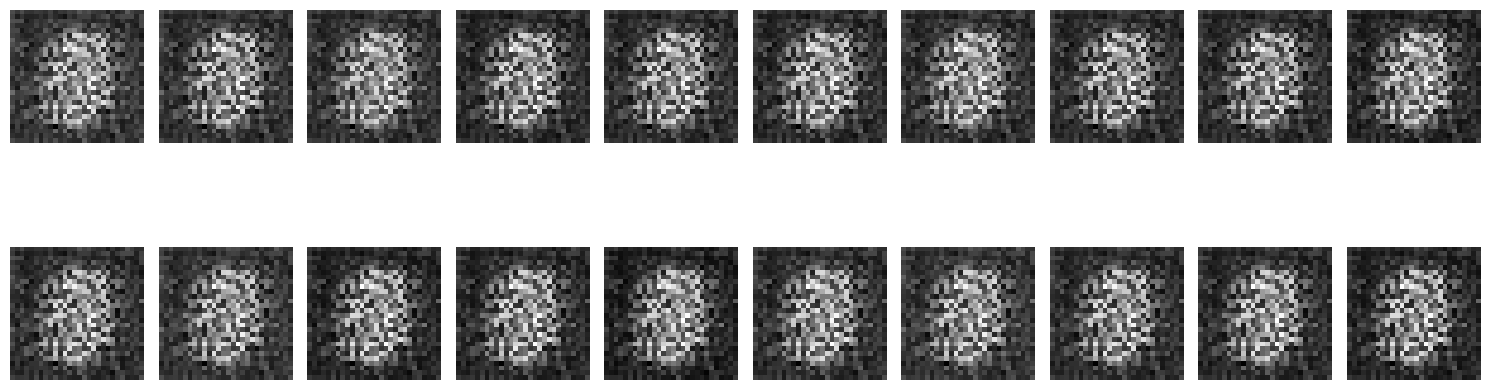

  5%|▌         | 20/400 [02:02<40:00,  6.32s/it]

21


  5%|▌         | 21/400 [02:08<39:12,  6.21s/it]

Epoch [21/400], D Loss: 0.5541, G Loss: 2.9609
22


  6%|▌         | 22/400 [02:14<38:17,  6.08s/it]

Epoch [22/400], D Loss: 1.4578, G Loss: 1.8701
23


  6%|▌         | 23/400 [02:20<37:56,  6.04s/it]

Epoch [23/400], D Loss: 1.1484, G Loss: 2.4398
24


  6%|▌         | 24/400 [02:27<38:50,  6.20s/it]

Epoch [24/400], D Loss: 0.6795, G Loss: 3.3423
25


  6%|▋         | 25/400 [02:32<37:56,  6.07s/it]

Epoch [25/400], D Loss: 0.6135, G Loss: 3.2813
26


  6%|▋         | 26/400 [02:38<37:40,  6.04s/it]

Epoch [26/400], D Loss: 0.5617, G Loss: 2.2602
27


  7%|▋         | 27/400 [02:44<37:08,  5.97s/it]

Epoch [27/400], D Loss: 0.5475, G Loss: 1.9970
28


  7%|▋         | 28/400 [02:50<36:58,  5.96s/it]

Epoch [28/400], D Loss: 0.8227, G Loss: 1.8904
29


  7%|▋         | 29/400 [02:56<36:50,  5.96s/it]

Epoch [29/400], D Loss: 0.9276, G Loss: 2.8644
30
Epoch [30/400], D Loss: 1.8297, G Loss: 1.7983


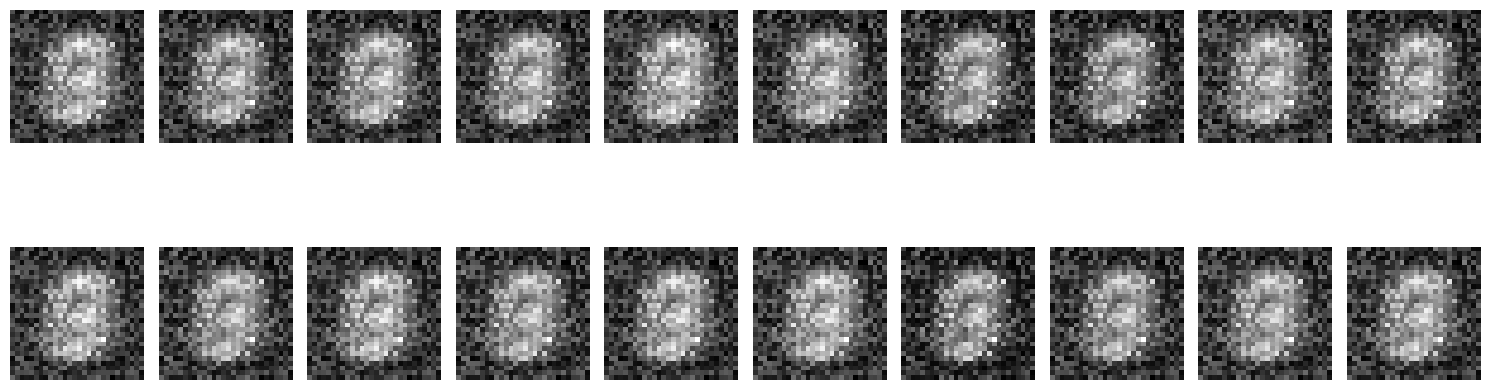

  8%|▊         | 30/400 [03:03<39:11,  6.36s/it]

31


  8%|▊         | 31/400 [03:09<38:15,  6.22s/it]

Epoch [31/400], D Loss: 0.8939, G Loss: 3.3427
32


  8%|▊         | 32/400 [03:15<37:03,  6.04s/it]

Epoch [32/400], D Loss: 1.3666, G Loss: 3.9560
33


  8%|▊         | 33/400 [03:21<36:42,  6.00s/it]

Epoch [33/400], D Loss: 1.5359, G Loss: 2.7899
34


  8%|▊         | 34/400 [03:26<36:11,  5.93s/it]

Epoch [34/400], D Loss: 0.8494, G Loss: 3.3313
35


  9%|▉         | 35/400 [03:33<36:18,  5.97s/it]

Epoch [35/400], D Loss: 1.1439, G Loss: 2.0093
36


  9%|▉         | 36/400 [03:38<35:39,  5.88s/it]

Epoch [36/400], D Loss: 1.5668, G Loss: 1.8015
37


  9%|▉         | 37/400 [03:44<34:59,  5.78s/it]

Epoch [37/400], D Loss: 0.5877, G Loss: 2.0049
38


 10%|▉         | 38/400 [03:49<34:37,  5.74s/it]

Epoch [38/400], D Loss: 1.4560, G Loss: 1.1239
39


 10%|▉         | 39/400 [03:55<34:04,  5.66s/it]

Epoch [39/400], D Loss: 0.9380, G Loss: 1.7162
40
Epoch [40/400], D Loss: 0.4939, G Loss: 2.5758


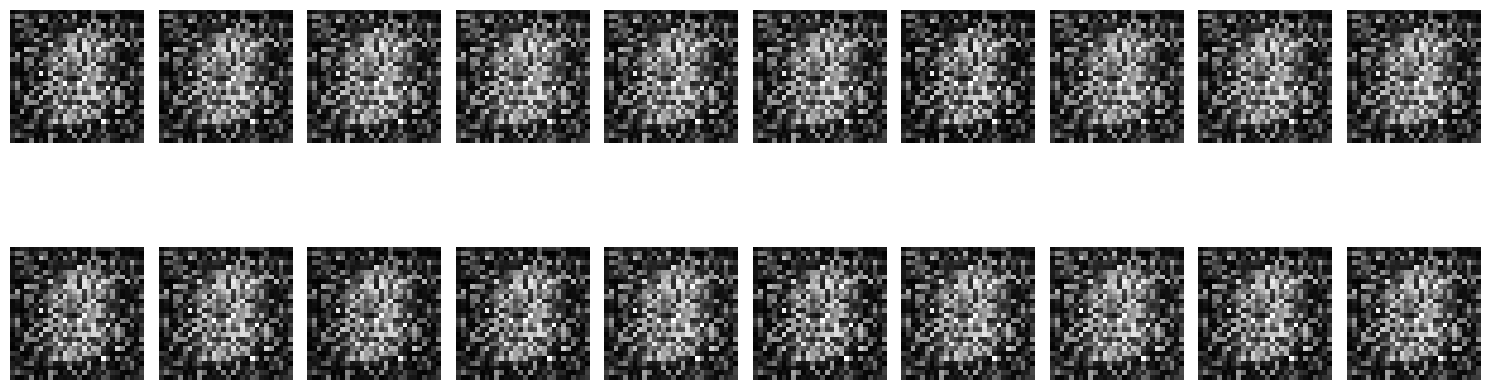

 10%|█         | 40/400 [04:01<35:04,  5.85s/it]

41


 10%|█         | 41/400 [04:07<35:35,  5.95s/it]

Epoch [41/400], D Loss: 0.4940, G Loss: 2.9033
42


 10%|█         | 42/400 [04:13<34:40,  5.81s/it]

Epoch [42/400], D Loss: 0.7104, G Loss: 2.3246
43


 11%|█         | 43/400 [04:18<34:07,  5.74s/it]

Epoch [43/400], D Loss: 0.3454, G Loss: 2.5511
44


 11%|█         | 44/400 [04:24<33:40,  5.68s/it]

Epoch [44/400], D Loss: 0.4597, G Loss: 2.4186
45


 11%|█▏        | 45/400 [04:29<33:20,  5.63s/it]

Epoch [45/400], D Loss: 0.4905, G Loss: 2.4923
46


 12%|█▏        | 46/400 [04:35<33:17,  5.64s/it]

Epoch [46/400], D Loss: 0.4301, G Loss: 3.1384
47


 12%|█▏        | 47/400 [04:41<33:17,  5.66s/it]

Epoch [47/400], D Loss: 0.2081, G Loss: 3.5322
48


 12%|█▏        | 48/400 [04:46<32:54,  5.61s/it]

Epoch [48/400], D Loss: 0.2691, G Loss: 3.1610
49


 12%|█▏        | 49/400 [04:52<32:32,  5.56s/it]

Epoch [49/400], D Loss: 0.2513, G Loss: 3.5799
50
Epoch [50/400], D Loss: 0.2739, G Loss: 4.0008


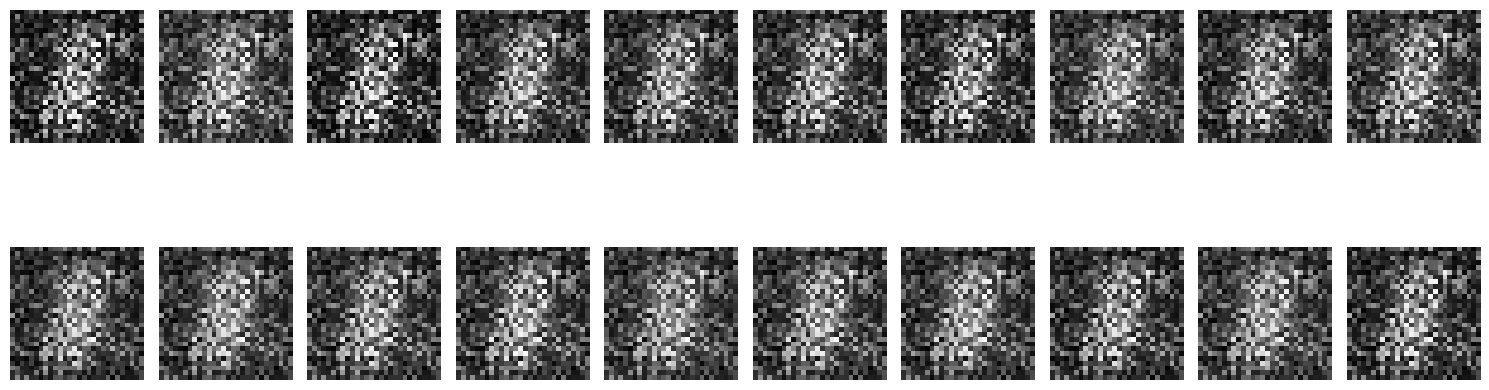

 12%|█▎        | 50/400 [04:58<33:56,  5.82s/it]

51


 13%|█▎        | 51/400 [05:04<33:08,  5.70s/it]

Epoch [51/400], D Loss: 0.4834, G Loss: 3.5678
52


 13%|█▎        | 52/400 [05:10<33:51,  5.84s/it]

Epoch [52/400], D Loss: 0.8719, G Loss: 4.1621
53


 13%|█▎        | 53/400 [05:15<33:34,  5.81s/it]

Epoch [53/400], D Loss: 0.5540, G Loss: 3.3389
54


 14%|█▎        | 54/400 [05:22<33:58,  5.89s/it]

Epoch [54/400], D Loss: 0.3472, G Loss: 4.4055
55


 14%|█▍        | 55/400 [05:28<34:26,  5.99s/it]

Epoch [55/400], D Loss: 0.5542, G Loss: 3.9953
56


 14%|█▍        | 56/400 [05:34<34:36,  6.04s/it]

Epoch [56/400], D Loss: 0.2645, G Loss: 3.9584
57


 14%|█▍        | 57/400 [05:40<35:22,  6.19s/it]

Epoch [57/400], D Loss: 0.1508, G Loss: 4.0482
58


 14%|█▍        | 58/400 [05:47<35:16,  6.19s/it]

Epoch [58/400], D Loss: 0.2145, G Loss: 3.7110
59


 15%|█▍        | 59/400 [05:53<34:52,  6.14s/it]

Epoch [59/400], D Loss: 0.1789, G Loss: 3.9107
60
Epoch [60/400], D Loss: 0.2396, G Loss: 4.3219


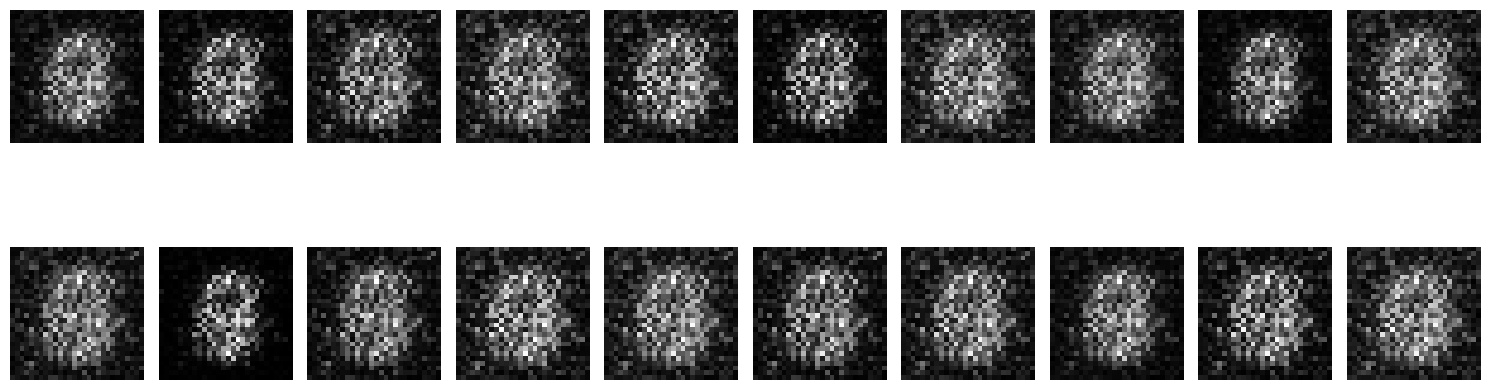

 15%|█▌        | 60/400 [06:00<36:11,  6.39s/it]

61


 15%|█▌        | 61/400 [06:06<35:37,  6.30s/it]

Epoch [61/400], D Loss: 0.2346, G Loss: 4.3728
62


 16%|█▌        | 62/400 [06:12<35:21,  6.28s/it]

Epoch [62/400], D Loss: 0.2580, G Loss: 4.3732
63


 16%|█▌        | 63/400 [06:18<34:31,  6.15s/it]

Epoch [63/400], D Loss: 0.3346, G Loss: 3.8147
64


 16%|█▌        | 64/400 [06:23<33:33,  5.99s/it]

Epoch [64/400], D Loss: 0.4051, G Loss: 3.8763
65


 16%|█▋        | 65/400 [06:29<32:49,  5.88s/it]

Epoch [65/400], D Loss: 0.4748, G Loss: 4.5956
66


 16%|█▋        | 66/400 [06:34<31:58,  5.74s/it]

Epoch [66/400], D Loss: 0.5707, G Loss: 4.9457
67


 17%|█▋        | 67/400 [06:40<31:26,  5.67s/it]

Epoch [67/400], D Loss: 0.7052, G Loss: 4.6810
68


 17%|█▋        | 68/400 [06:46<31:51,  5.76s/it]

Epoch [68/400], D Loss: 0.3250, G Loss: 5.0052
69


 17%|█▋        | 69/400 [06:51<31:13,  5.66s/it]

Epoch [69/400], D Loss: 0.4834, G Loss: 3.9767
70
Epoch [70/400], D Loss: 0.2390, G Loss: 4.1019


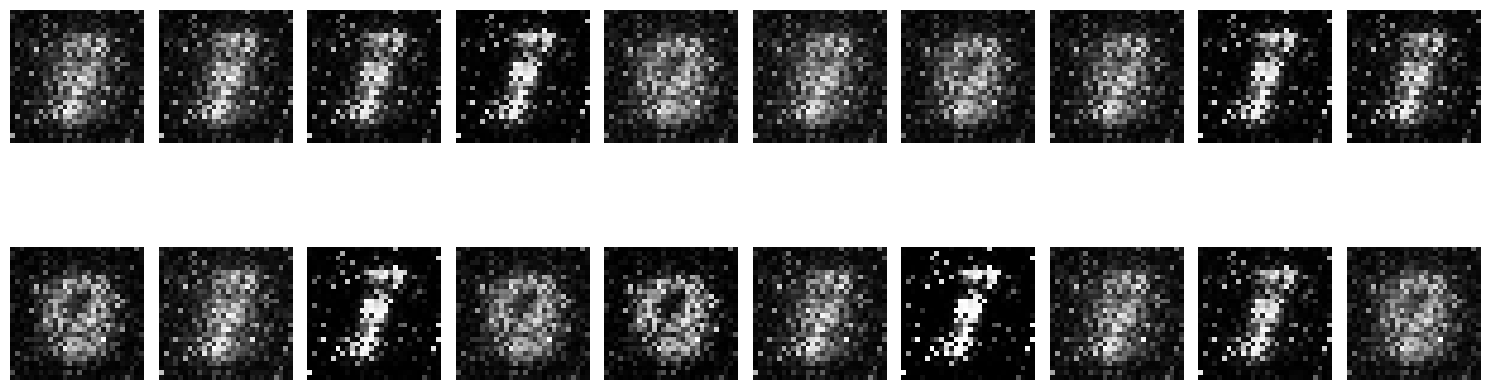

 18%|█▊        | 70/400 [06:58<32:07,  5.84s/it]

71


 18%|█▊        | 71/400 [07:03<32:00,  5.84s/it]

Epoch [71/400], D Loss: 0.2269, G Loss: 5.2044
72


 18%|█▊        | 72/400 [07:09<32:07,  5.88s/it]

Epoch [72/400], D Loss: 0.2374, G Loss: 4.9634
73


 18%|█▊        | 73/400 [07:15<32:10,  5.91s/it]

Epoch [73/400], D Loss: 0.1969, G Loss: 5.8892
74


 18%|█▊        | 74/400 [07:22<32:48,  6.04s/it]

Epoch [74/400], D Loss: 0.3935, G Loss: 4.8552
75


 19%|█▉        | 75/400 [07:28<32:29,  6.00s/it]

Epoch [75/400], D Loss: 0.2011, G Loss: 3.9866
76


 19%|█▉        | 76/400 [07:34<32:12,  5.96s/it]

Epoch [76/400], D Loss: 0.1703, G Loss: 4.2852
77


 19%|█▉        | 77/400 [07:40<32:05,  5.96s/it]

Epoch [77/400], D Loss: 0.1433, G Loss: 4.3527
78


 20%|█▉        | 78/400 [07:46<32:08,  5.99s/it]

Epoch [78/400], D Loss: 0.2545, G Loss: 4.8087
79


 20%|█▉        | 79/400 [07:52<32:28,  6.07s/it]

Epoch [79/400], D Loss: 0.3353, G Loss: 4.9637
80
Epoch [80/400], D Loss: 0.7322, G Loss: 5.0134


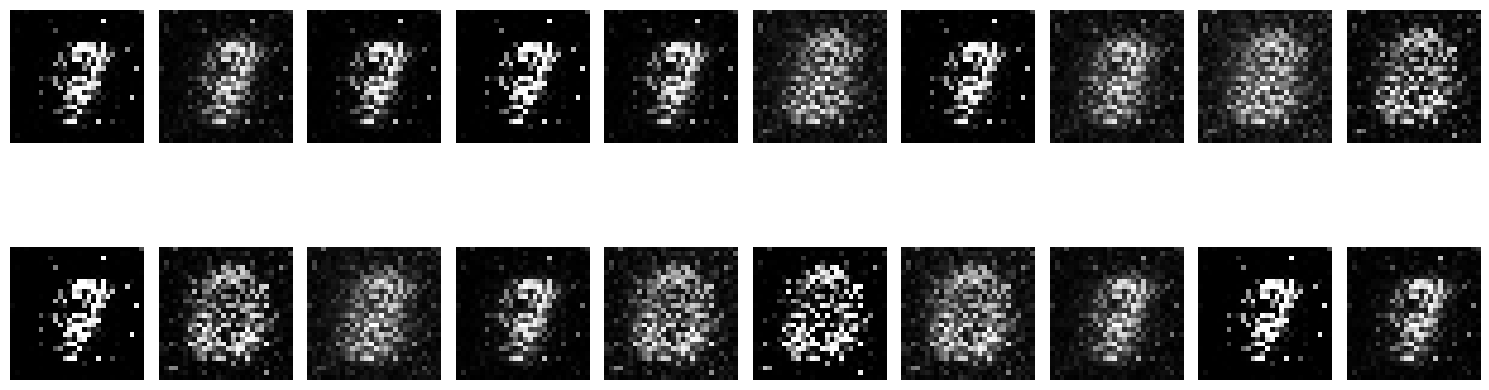

 20%|██        | 80/400 [07:59<33:26,  6.27s/it]

81


 20%|██        | 81/400 [08:04<31:54,  6.00s/it]

Epoch [81/400], D Loss: 0.4605, G Loss: 3.9786
82


 20%|██        | 82/400 [08:09<30:52,  5.82s/it]

Epoch [82/400], D Loss: 0.4326, G Loss: 3.7981
83


 21%|██        | 83/400 [08:15<30:10,  5.71s/it]

Epoch [83/400], D Loss: 0.4850, G Loss: 3.8892
84


 21%|██        | 84/400 [08:20<29:35,  5.62s/it]

Epoch [84/400], D Loss: 0.2151, G Loss: 3.7925
85


 21%|██▏       | 85/400 [08:26<30:07,  5.74s/it]

Epoch [85/400], D Loss: 0.2220, G Loss: 5.3163
86


 22%|██▏       | 86/400 [08:32<29:26,  5.63s/it]

Epoch [86/400], D Loss: 0.2165, G Loss: 4.8707
87


 22%|██▏       | 87/400 [08:37<29:02,  5.57s/it]

Epoch [87/400], D Loss: 0.2217, G Loss: 5.0213
88


 22%|██▏       | 88/400 [08:42<28:39,  5.51s/it]

Epoch [88/400], D Loss: 0.2157, G Loss: 6.3582
89


 22%|██▏       | 89/400 [08:48<28:30,  5.50s/it]

Epoch [89/400], D Loss: 0.2869, G Loss: 7.2669
90
Epoch [90/400], D Loss: 0.3793, G Loss: 7.2648


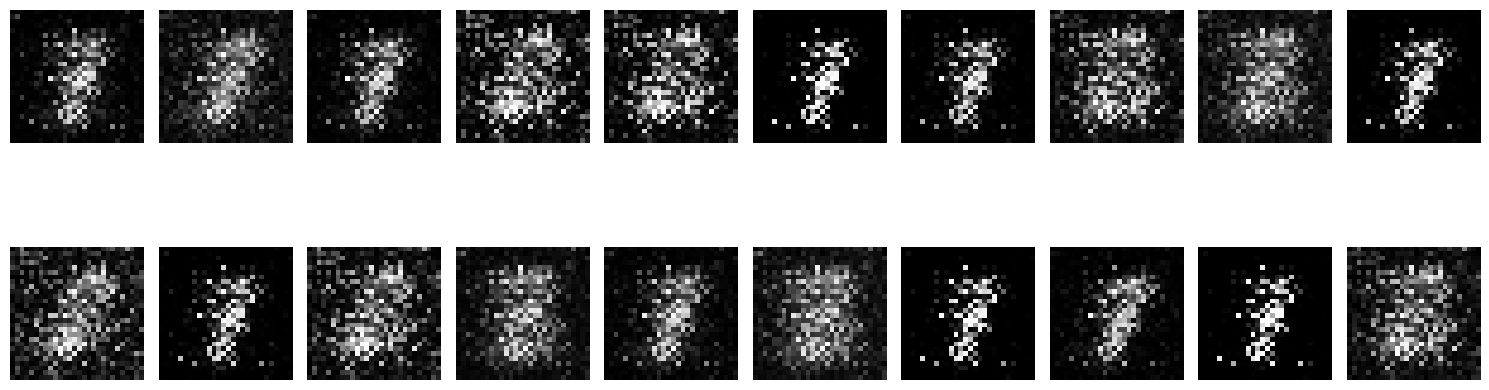

 22%|██▎       | 90/400 [08:54<29:46,  5.76s/it]

91


 23%|██▎       | 91/400 [09:00<29:12,  5.67s/it]

Epoch [91/400], D Loss: 0.3244, G Loss: 6.4267
92


 23%|██▎       | 92/400 [09:05<28:45,  5.60s/it]

Epoch [92/400], D Loss: 0.4937, G Loss: 4.6502
93


 23%|██▎       | 93/400 [09:11<28:23,  5.55s/it]

Epoch [93/400], D Loss: 0.3433, G Loss: 4.4873
94


 24%|██▎       | 94/400 [09:16<28:12,  5.53s/it]

Epoch [94/400], D Loss: 0.2224, G Loss: 4.7088
95


 24%|██▍       | 95/400 [09:21<27:56,  5.50s/it]

Epoch [95/400], D Loss: 0.2391, G Loss: 5.0657
96


 24%|██▍       | 96/400 [09:27<28:32,  5.63s/it]

Epoch [96/400], D Loss: 0.3970, G Loss: 5.4239
97


 24%|██▍       | 97/400 [09:33<28:01,  5.55s/it]

Epoch [97/400], D Loss: 0.2078, G Loss: 4.3872
98


 24%|██▍       | 98/400 [09:38<27:45,  5.51s/it]

Epoch [98/400], D Loss: 0.2263, G Loss: 4.6180
99


 25%|██▍       | 99/400 [09:44<27:26,  5.47s/it]

Epoch [99/400], D Loss: 0.2784, G Loss: 4.0742
100
Epoch [100/400], D Loss: 0.3084, G Loss: 5.4213


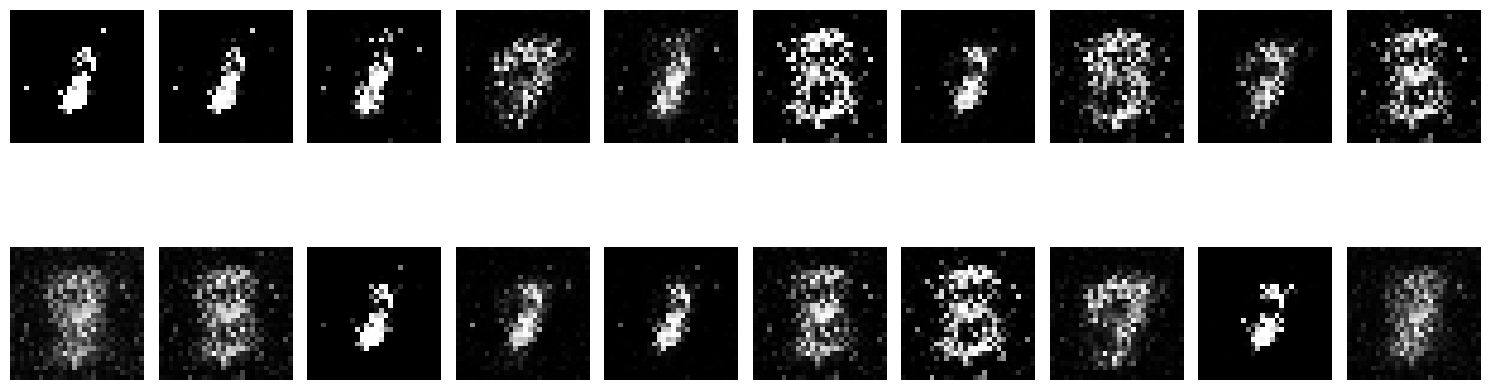

 25%|██▌       | 100/400 [09:50<28:41,  5.74s/it]

101


 25%|██▌       | 101/400 [09:55<28:12,  5.66s/it]

Epoch [101/400], D Loss: 0.2425, G Loss: 4.8176
102


 26%|██▌       | 102/400 [10:01<28:27,  5.73s/it]

Epoch [102/400], D Loss: 0.4192, G Loss: 5.0387
103


 26%|██▌       | 103/400 [10:07<28:08,  5.68s/it]

Epoch [103/400], D Loss: 0.2096, G Loss: 4.6407
104


 26%|██▌       | 104/400 [10:12<27:37,  5.60s/it]

Epoch [104/400], D Loss: 0.2908, G Loss: 4.3343
105


 26%|██▋       | 105/400 [10:18<27:20,  5.56s/it]

Epoch [105/400], D Loss: 0.3679, G Loss: 4.6438
106


 26%|██▋       | 106/400 [10:23<27:14,  5.56s/it]

Epoch [106/400], D Loss: 0.2537, G Loss: 4.5406
107


 27%|██▋       | 107/400 [10:29<27:02,  5.54s/it]

Epoch [107/400], D Loss: 0.2260, G Loss: 4.6504
108


 27%|██▋       | 108/400 [10:35<27:29,  5.65s/it]

Epoch [108/400], D Loss: 0.1950, G Loss: 4.7845
109


 27%|██▋       | 109/400 [10:40<27:06,  5.59s/it]

Epoch [109/400], D Loss: 0.2515, G Loss: 4.5476
110
Epoch [110/400], D Loss: 0.2836, G Loss: 5.3674


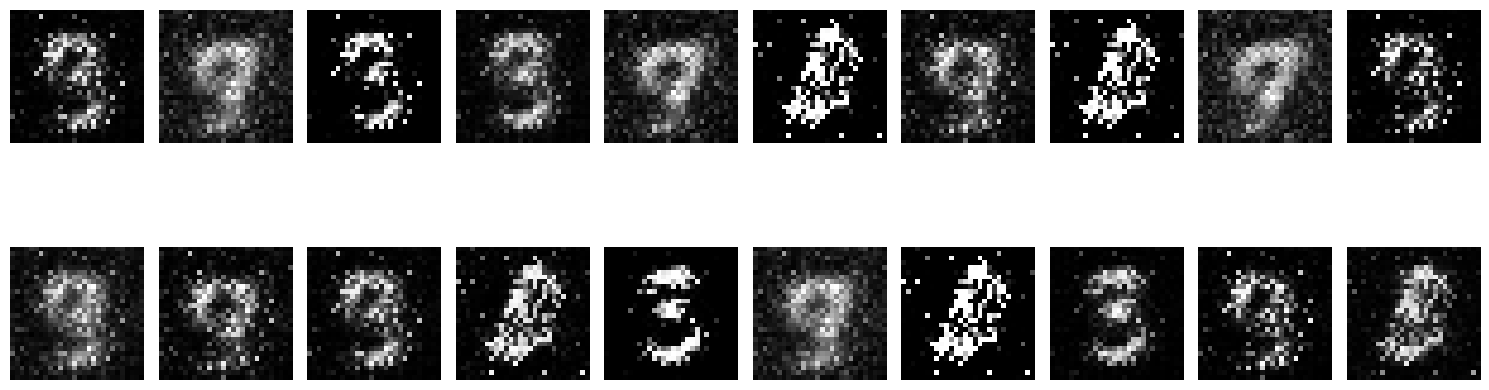

 28%|██▊       | 110/400 [10:46<28:01,  5.80s/it]

111


 28%|██▊       | 111/400 [10:52<27:29,  5.71s/it]

Epoch [111/400], D Loss: 0.4455, G Loss: 4.1065
112


 28%|██▊       | 112/400 [10:57<27:03,  5.64s/it]

Epoch [112/400], D Loss: 0.3011, G Loss: 4.7232
113


 28%|██▊       | 113/400 [11:03<26:59,  5.64s/it]

Epoch [113/400], D Loss: 0.5072, G Loss: 5.8936
114


 28%|██▊       | 114/400 [11:09<27:01,  5.67s/it]

Epoch [114/400], D Loss: 0.4718, G Loss: 4.3447
115


 29%|██▉       | 115/400 [11:14<26:34,  5.59s/it]

Epoch [115/400], D Loss: 0.4203, G Loss: 4.2935
116


 29%|██▉       | 116/400 [11:20<26:21,  5.57s/it]

Epoch [116/400], D Loss: 0.2441, G Loss: 3.9923
117


 29%|██▉       | 117/400 [11:25<26:22,  5.59s/it]

Epoch [117/400], D Loss: 0.2153, G Loss: 4.2798
118


 30%|██▉       | 118/400 [11:31<26:13,  5.58s/it]

Epoch [118/400], D Loss: 0.2881, G Loss: 6.0432
119


 30%|██▉       | 119/400 [11:37<26:31,  5.66s/it]

Epoch [119/400], D Loss: 0.3158, G Loss: 5.2729
120
Epoch [120/400], D Loss: 0.2699, G Loss: 4.9821


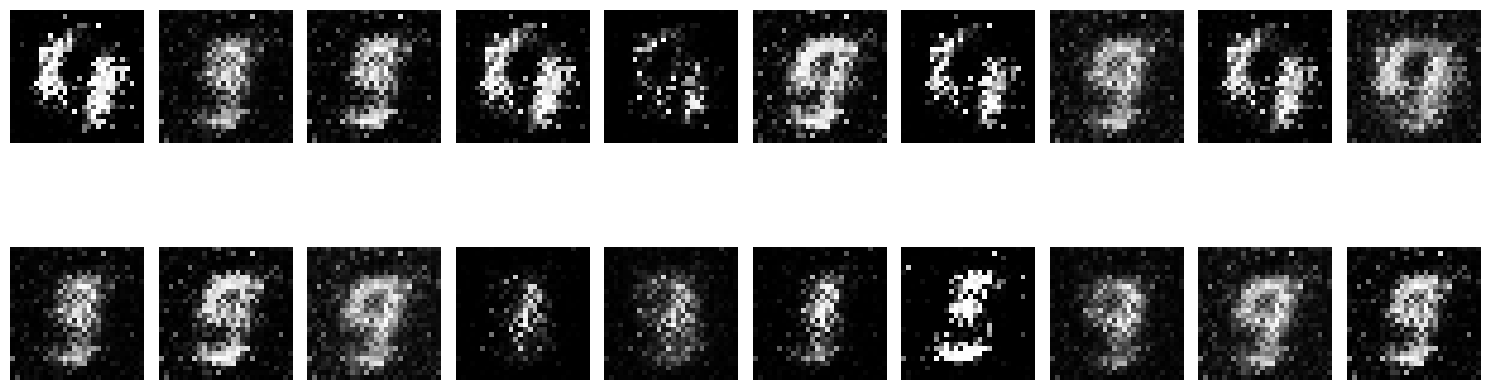

 30%|███       | 120/400 [11:43<27:25,  5.88s/it]

121


 30%|███       | 121/400 [11:49<26:50,  5.77s/it]

Epoch [121/400], D Loss: 0.1915, G Loss: 4.6926
122


 30%|███       | 122/400 [11:54<26:16,  5.67s/it]

Epoch [122/400], D Loss: 0.2910, G Loss: 6.0230
123


 31%|███       | 123/400 [12:00<25:56,  5.62s/it]

Epoch [123/400], D Loss: 0.2952, G Loss: 5.5325
124


 31%|███       | 124/400 [12:05<26:00,  5.65s/it]

Epoch [124/400], D Loss: 0.4315, G Loss: 4.2276
125


 31%|███▏      | 125/400 [12:11<26:18,  5.74s/it]

Epoch [125/400], D Loss: 0.3598, G Loss: 4.3625
126


 32%|███▏      | 126/400 [12:17<25:57,  5.69s/it]

Epoch [126/400], D Loss: 0.3405, G Loss: 3.9886
127


 32%|███▏      | 127/400 [12:22<25:30,  5.61s/it]

Epoch [127/400], D Loss: 0.2428, G Loss: 4.2027
128


 32%|███▏      | 128/400 [12:28<25:18,  5.58s/it]

Epoch [128/400], D Loss: 0.2543, G Loss: 4.5826
129


 32%|███▏      | 129/400 [12:33<25:14,  5.59s/it]

Epoch [129/400], D Loss: 0.2552, G Loss: 5.0049
130
Epoch [130/400], D Loss: 0.3730, G Loss: 5.2567


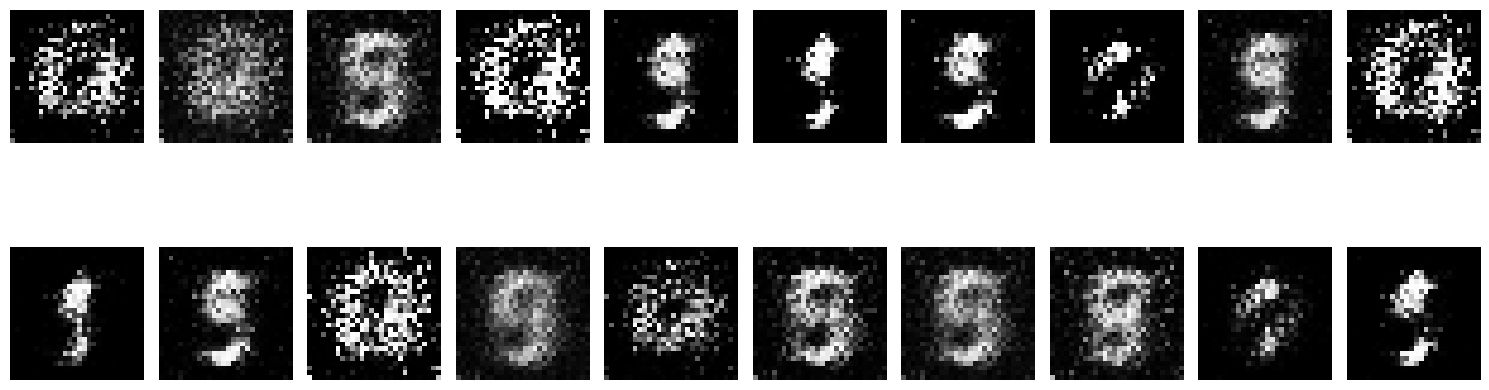

 32%|███▎      | 130/400 [12:40<26:13,  5.83s/it]

131


 33%|███▎      | 131/400 [12:46<26:07,  5.83s/it]

Epoch [131/400], D Loss: 0.4296, G Loss: 4.7822
132


 33%|███▎      | 132/400 [12:51<25:34,  5.72s/it]

Epoch [132/400], D Loss: 0.3413, G Loss: 4.3420
133


 33%|███▎      | 133/400 [12:57<25:11,  5.66s/it]

Epoch [133/400], D Loss: 0.3015, G Loss: 4.3193
134


 34%|███▎      | 134/400 [13:02<25:09,  5.67s/it]

Epoch [134/400], D Loss: 0.1936, G Loss: 4.7321
135


 34%|███▍      | 135/400 [13:08<24:54,  5.64s/it]

Epoch [135/400], D Loss: 0.2258, G Loss: 4.5446
136


 34%|███▍      | 136/400 [13:14<25:13,  5.73s/it]

Epoch [136/400], D Loss: 0.1674, G Loss: 5.3842
137


 34%|███▍      | 137/400 [13:19<24:57,  5.69s/it]

Epoch [137/400], D Loss: 0.1629, G Loss: 5.3843
138


 34%|███▍      | 138/400 [13:25<24:40,  5.65s/it]

Epoch [138/400], D Loss: 0.2604, G Loss: 5.5969
139


 35%|███▍      | 139/400 [13:31<24:24,  5.61s/it]

Epoch [139/400], D Loss: 0.2617, G Loss: 5.3398
140
Epoch [140/400], D Loss: 0.3211, G Loss: 5.0182


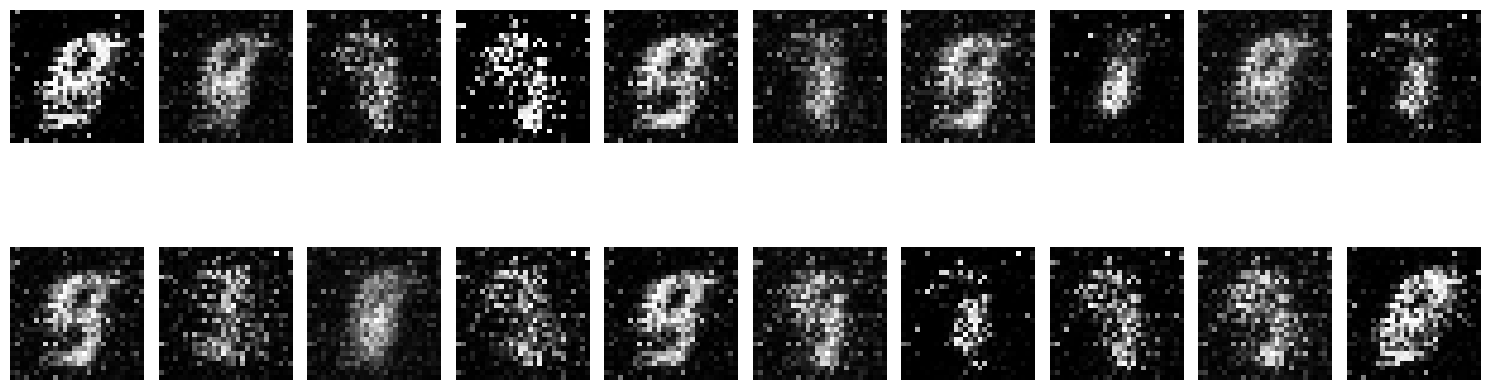

 35%|███▌      | 140/400 [13:37<25:27,  5.87s/it]

141


 35%|███▌      | 141/400 [13:42<24:48,  5.75s/it]

Epoch [141/400], D Loss: 0.2577, G Loss: 6.3892
142


 36%|███▌      | 142/400 [13:48<25:00,  5.82s/it]

Epoch [142/400], D Loss: 0.4226, G Loss: 5.6270
143


 36%|███▌      | 143/400 [13:54<24:30,  5.72s/it]

Epoch [143/400], D Loss: 0.3418, G Loss: 6.0910
144


 36%|███▌      | 144/400 [13:59<24:10,  5.67s/it]

Epoch [144/400], D Loss: 0.2186, G Loss: 5.6795
145


 36%|███▋      | 145/400 [14:05<23:52,  5.62s/it]

Epoch [145/400], D Loss: 0.1955, G Loss: 5.6221
146


 36%|███▋      | 146/400 [14:11<23:43,  5.60s/it]

Epoch [146/400], D Loss: 0.1523, G Loss: 5.7306
147


 37%|███▋      | 147/400 [14:16<23:31,  5.58s/it]

Epoch [147/400], D Loss: 0.1373, G Loss: 5.1119
148


 37%|███▋      | 148/400 [14:22<23:56,  5.70s/it]

Epoch [148/400], D Loss: 0.1385, G Loss: 5.5594
149


 37%|███▋      | 149/400 [14:28<23:38,  5.65s/it]

Epoch [149/400], D Loss: 0.1275, G Loss: 5.2263
150
Epoch [150/400], D Loss: 0.1736, G Loss: 5.0216


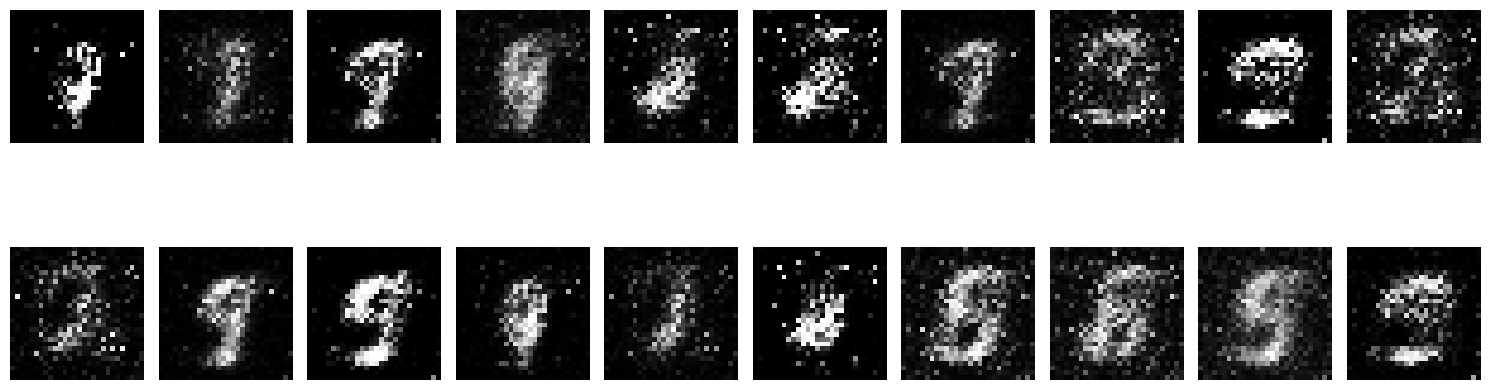

 38%|███▊      | 150/400 [14:34<24:26,  5.86s/it]

151


 38%|███▊      | 151/400 [14:40<24:00,  5.78s/it]

Epoch [151/400], D Loss: 0.2506, G Loss: 5.6279
152


 38%|███▊      | 152/400 [14:45<23:38,  5.72s/it]

Epoch [152/400], D Loss: 0.1628, G Loss: 5.7859
153


 38%|███▊      | 153/400 [14:51<23:50,  5.79s/it]

Epoch [153/400], D Loss: 0.1999, G Loss: 5.8124
154


 38%|███▊      | 154/400 [14:57<23:27,  5.72s/it]

Epoch [154/400], D Loss: 0.2198, G Loss: 5.1920
155


 39%|███▉      | 155/400 [15:02<23:06,  5.66s/it]

Epoch [155/400], D Loss: 0.1935, G Loss: 5.3597
156


 39%|███▉      | 156/400 [15:08<22:49,  5.61s/it]

Epoch [156/400], D Loss: 0.2240, G Loss: 5.5569
157


 39%|███▉      | 157/400 [15:13<22:36,  5.58s/it]

Epoch [157/400], D Loss: 0.1864, G Loss: 5.3680
158


 40%|███▉      | 158/400 [15:19<22:30,  5.58s/it]

Epoch [158/400], D Loss: 0.1947, G Loss: 4.6529
159


 40%|███▉      | 159/400 [15:25<22:57,  5.71s/it]

Epoch [159/400], D Loss: 0.1613, G Loss: 5.3028
160
Epoch [160/400], D Loss: 0.2145, G Loss: 5.1500


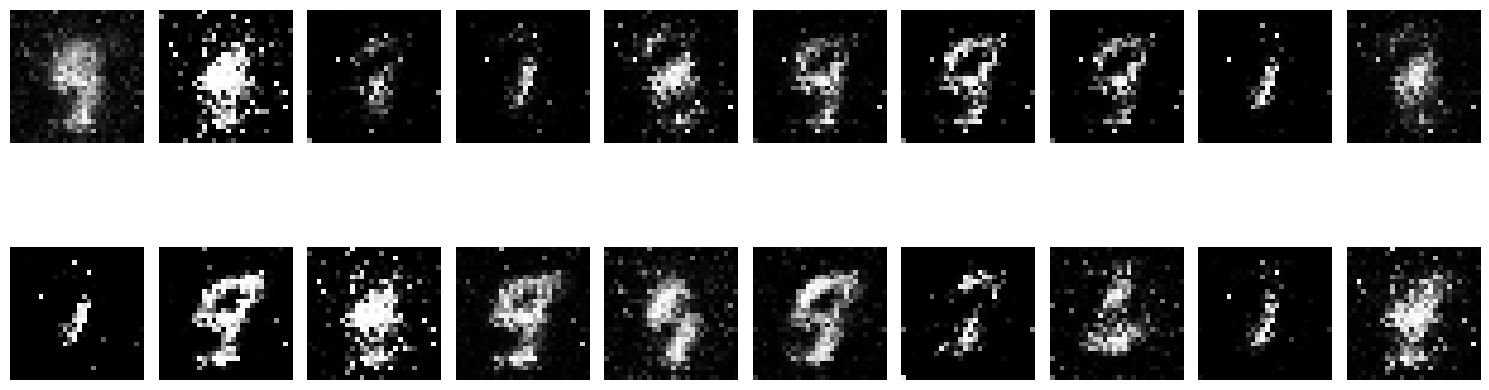

 40%|████      | 160/400 [15:31<23:47,  5.95s/it]

161


 40%|████      | 161/400 [15:37<23:09,  5.81s/it]

Epoch [161/400], D Loss: 0.4198, G Loss: 6.6984
162


 40%|████      | 162/400 [15:42<22:44,  5.73s/it]

Epoch [162/400], D Loss: 0.2930, G Loss: 4.0832
163


 41%|████      | 163/400 [15:48<22:31,  5.70s/it]

Epoch [163/400], D Loss: 0.2372, G Loss: 4.4763
164


 41%|████      | 164/400 [15:53<22:12,  5.65s/it]

Epoch [164/400], D Loss: 0.2226, G Loss: 4.3274
165


 41%|████▏     | 165/400 [15:59<22:28,  5.74s/it]

Epoch [165/400], D Loss: 0.2157, G Loss: 4.2725
166


 42%|████▏     | 166/400 [16:05<22:08,  5.68s/it]

Epoch [166/400], D Loss: 0.2213, G Loss: 4.5119
167


 42%|████▏     | 167/400 [16:10<21:46,  5.61s/it]

Epoch [167/400], D Loss: 0.2428, G Loss: 4.6081
168


 42%|████▏     | 168/400 [16:16<21:43,  5.62s/it]

Epoch [168/400], D Loss: 0.2109, G Loss: 4.7227
169


 42%|████▏     | 169/400 [16:22<21:37,  5.62s/it]

Epoch [169/400], D Loss: 0.2580, G Loss: 4.7380
170
Epoch [170/400], D Loss: 0.2159, G Loss: 4.9541


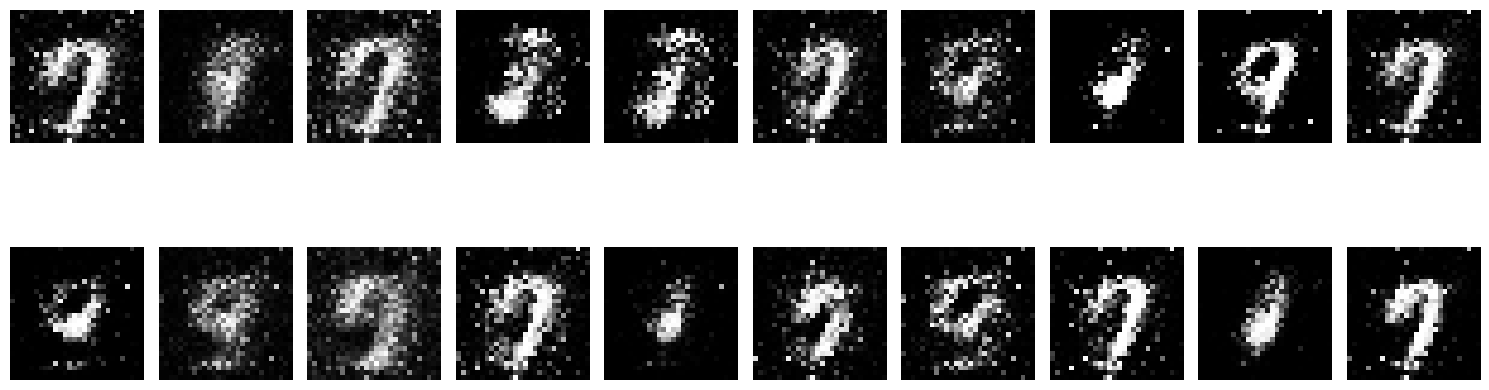

 42%|████▎     | 170/400 [16:28<22:51,  5.96s/it]

171


 43%|████▎     | 171/400 [16:34<22:17,  5.84s/it]

Epoch [171/400], D Loss: 0.2518, G Loss: 4.8837
172


 43%|████▎     | 172/400 [16:40<21:57,  5.78s/it]

Epoch [172/400], D Loss: 0.2599, G Loss: 4.2155
173


 43%|████▎     | 173/400 [16:45<21:36,  5.71s/it]

Epoch [173/400], D Loss: 0.1917, G Loss: 4.7471
174


 44%|████▎     | 174/400 [16:51<21:16,  5.65s/it]

Epoch [174/400], D Loss: 0.2134, G Loss: 4.7696
175


 44%|████▍     | 175/400 [16:56<21:04,  5.62s/it]

Epoch [175/400], D Loss: 0.1584, G Loss: 5.1305
176


 44%|████▍     | 176/400 [17:02<21:18,  5.71s/it]

Epoch [176/400], D Loss: 0.2262, G Loss: 4.8498
177


 44%|████▍     | 177/400 [17:08<21:01,  5.66s/it]

Epoch [177/400], D Loss: 0.1693, G Loss: 4.5257
178


 44%|████▍     | 178/400 [17:13<20:41,  5.59s/it]

Epoch [178/400], D Loss: 0.1754, G Loss: 4.4201
179


 45%|████▍     | 179/400 [17:19<20:35,  5.59s/it]

Epoch [179/400], D Loss: 0.1547, G Loss: 4.9075
180
Epoch [180/400], D Loss: 0.1759, G Loss: 5.5727


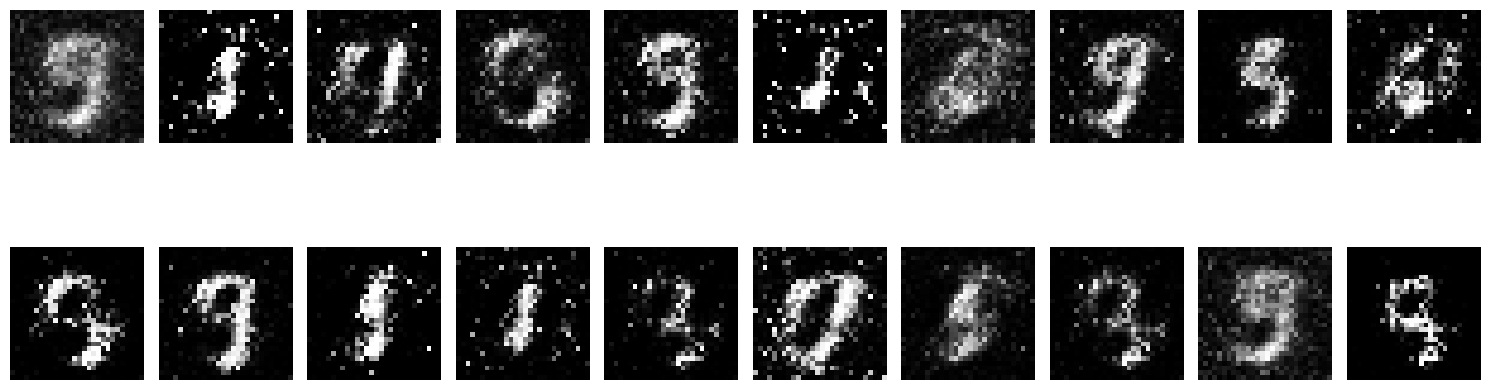

 45%|████▌     | 180/400 [17:25<21:15,  5.80s/it]

181


 45%|████▌     | 181/400 [17:31<21:23,  5.86s/it]

Epoch [181/400], D Loss: 0.2434, G Loss: 5.2384
182


 46%|████▌     | 182/400 [17:37<21:38,  5.96s/it]

Epoch [182/400], D Loss: 0.2980, G Loss: 5.0771
183


 46%|████▌     | 183/400 [17:43<21:29,  5.94s/it]

Epoch [183/400], D Loss: 0.3117, G Loss: 4.8794
184


 46%|████▌     | 184/400 [17:49<21:21,  5.93s/it]

Epoch [184/400], D Loss: 0.3573, G Loss: 5.6739
185


 46%|████▋     | 185/400 [17:55<21:14,  5.93s/it]

Epoch [185/400], D Loss: 0.3616, G Loss: 5.3585
186


 46%|████▋     | 186/400 [18:01<21:05,  5.91s/it]

Epoch [186/400], D Loss: 0.3111, G Loss: 4.5676
187


 47%|████▋     | 187/400 [18:07<21:33,  6.07s/it]

Epoch [187/400], D Loss: 0.2749, G Loss: 4.5193
188


 47%|████▋     | 188/400 [18:13<21:18,  6.03s/it]

Epoch [188/400], D Loss: 0.2422, G Loss: 4.5825
189


 47%|████▋     | 189/400 [18:19<21:09,  6.02s/it]

Epoch [189/400], D Loss: 0.2046, G Loss: 4.8163
190
Epoch [190/400], D Loss: 0.2087, G Loss: 4.9513


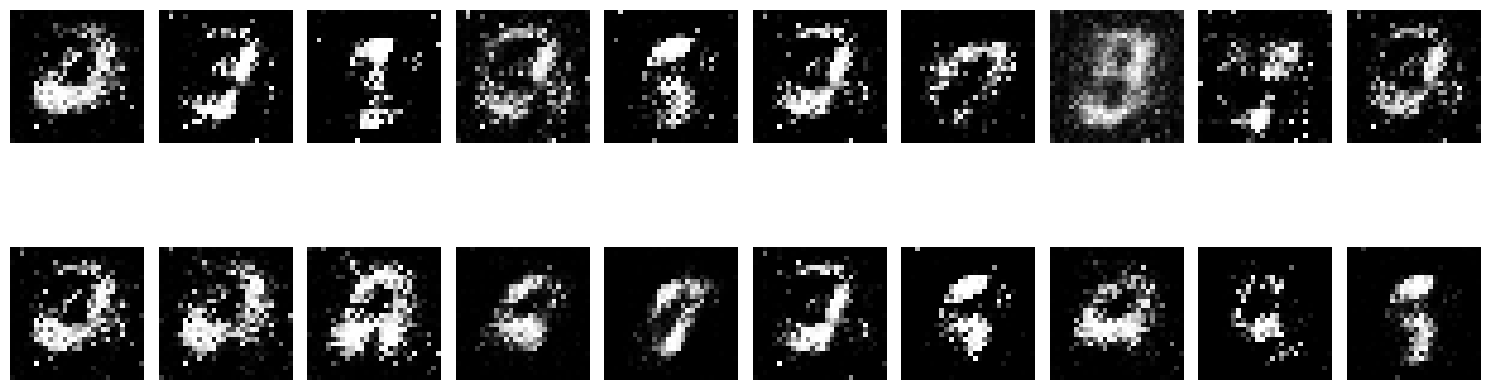

 48%|████▊     | 190/400 [18:26<22:03,  6.30s/it]

191


 48%|████▊     | 191/400 [18:32<21:06,  6.06s/it]

Epoch [191/400], D Loss: 0.2464, G Loss: 4.5478
192


 48%|████▊     | 192/400 [18:38<20:59,  6.05s/it]

Epoch [192/400], D Loss: 0.2068, G Loss: 4.8539
193


 48%|████▊     | 193/400 [18:43<20:23,  5.91s/it]

Epoch [193/400], D Loss: 0.3420, G Loss: 5.1564
194


 48%|████▊     | 194/400 [18:49<19:52,  5.79s/it]

Epoch [194/400], D Loss: 0.2656, G Loss: 4.4103
195


 49%|████▉     | 195/400 [18:54<19:31,  5.72s/it]

Epoch [195/400], D Loss: 0.2027, G Loss: 4.5006
196


 49%|████▉     | 196/400 [19:00<19:15,  5.66s/it]

Epoch [196/400], D Loss: 0.2352, G Loss: 4.6468
197


 49%|████▉     | 197/400 [19:05<19:00,  5.62s/it]

Epoch [197/400], D Loss: 0.2520, G Loss: 4.9425
198


 50%|████▉     | 198/400 [19:11<19:16,  5.73s/it]

Epoch [198/400], D Loss: 0.2775, G Loss: 4.5063
199


 50%|████▉     | 199/400 [19:17<18:58,  5.66s/it]

Epoch [199/400], D Loss: 0.2280, G Loss: 5.2596
200
Epoch [200/400], D Loss: 0.2734, G Loss: 5.5662


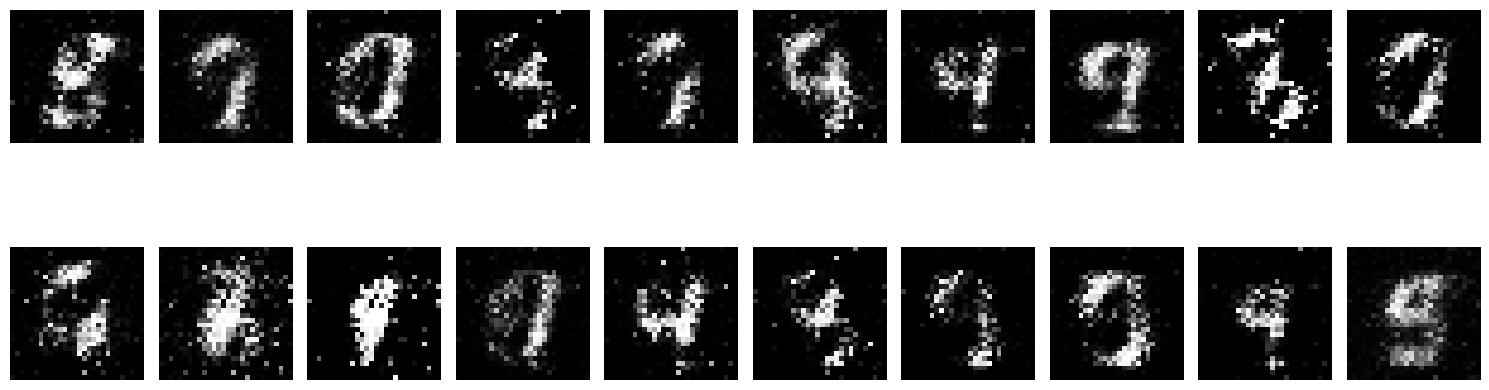

 50%|█████     | 200/400 [19:23<19:23,  5.82s/it]

201


 50%|█████     | 201/400 [19:29<18:59,  5.73s/it]

Epoch [201/400], D Loss: 0.3064, G Loss: 4.9265
202


 50%|█████     | 202/400 [19:34<18:42,  5.67s/it]

Epoch [202/400], D Loss: 0.3227, G Loss: 4.8353
203


 51%|█████     | 203/400 [19:40<18:25,  5.61s/it]

Epoch [203/400], D Loss: 0.2725, G Loss: 5.0614
204


 51%|█████     | 204/400 [19:46<18:47,  5.75s/it]

Epoch [204/400], D Loss: 0.2360, G Loss: 4.6655
205


 51%|█████▏    | 205/400 [19:51<18:26,  5.68s/it]

Epoch [205/400], D Loss: 0.1715, G Loss: 5.0494
206


 52%|█████▏    | 206/400 [19:57<18:16,  5.65s/it]

Epoch [206/400], D Loss: 0.2320, G Loss: 5.1142
207


 52%|█████▏    | 207/400 [20:02<17:59,  5.59s/it]

Epoch [207/400], D Loss: 0.2491, G Loss: 5.3228
208


 52%|█████▏    | 208/400 [20:08<17:47,  5.56s/it]

Epoch [208/400], D Loss: 0.2941, G Loss: 5.2858
209


 52%|█████▏    | 209/400 [20:13<17:48,  5.59s/it]

Epoch [209/400], D Loss: 0.2921, G Loss: 4.9090
210
Epoch [210/400], D Loss: 0.2582, G Loss: 4.7248


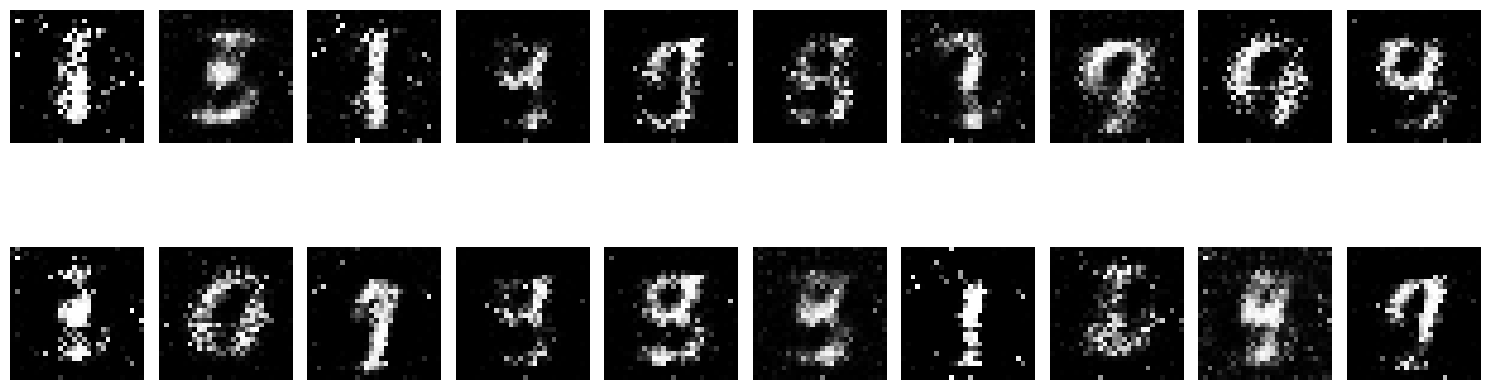

 52%|█████▎    | 210/400 [20:20<18:41,  5.90s/it]

211


 53%|█████▎    | 211/400 [20:26<18:18,  5.81s/it]

Epoch [211/400], D Loss: 0.2332, G Loss: 4.5138
212


 53%|█████▎    | 212/400 [20:31<17:56,  5.72s/it]

Epoch [212/400], D Loss: 0.2017, G Loss: 4.5020
213


 53%|█████▎    | 213/400 [20:37<17:40,  5.67s/it]

Epoch [213/400], D Loss: 0.2086, G Loss: 4.8345
214


 54%|█████▎    | 214/400 [20:42<17:26,  5.62s/it]

Epoch [214/400], D Loss: 0.2267, G Loss: 4.9180
215


 54%|█████▍    | 215/400 [20:48<17:47,  5.77s/it]

Epoch [215/400], D Loss: 0.2438, G Loss: 4.8525
216


 54%|█████▍    | 216/400 [20:54<17:32,  5.72s/it]

Epoch [216/400], D Loss: 0.2771, G Loss: 4.5264
217


 54%|█████▍    | 217/400 [20:59<17:18,  5.67s/it]

Epoch [217/400], D Loss: 0.2944, G Loss: 4.8723
218


 55%|█████▍    | 218/400 [21:05<17:10,  5.66s/it]

Epoch [218/400], D Loss: 0.2832, G Loss: 4.8257
219


 55%|█████▍    | 219/400 [21:11<16:59,  5.63s/it]

Epoch [219/400], D Loss: 0.2900, G Loss: 4.5660
220
Epoch [220/400], D Loss: 0.2777, G Loss: 4.6423


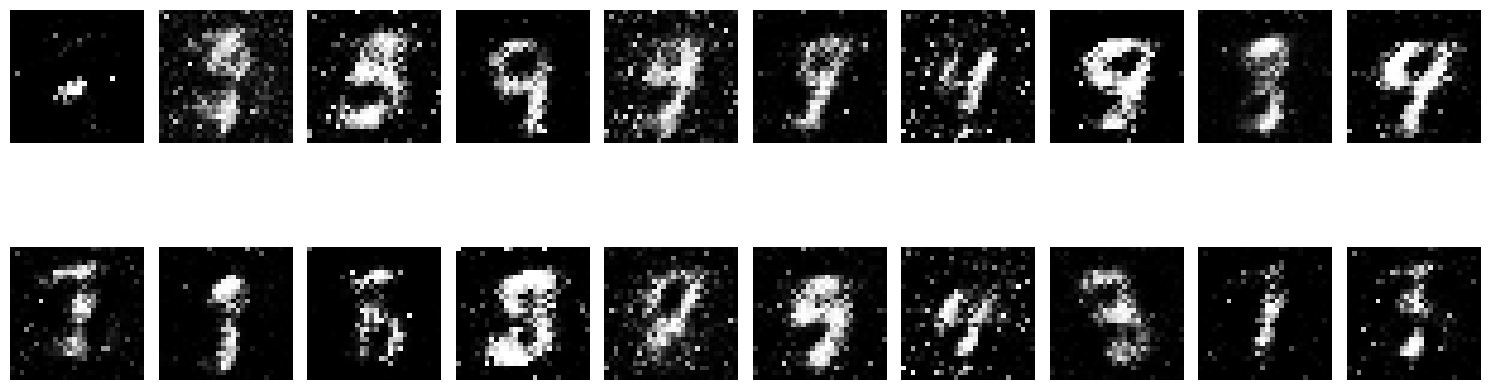

 55%|█████▌    | 220/400 [21:17<17:29,  5.83s/it]

221


 55%|█████▌    | 221/400 [21:23<17:31,  5.87s/it]

Epoch [221/400], D Loss: 0.3403, G Loss: 4.6096
222


 56%|█████▌    | 222/400 [21:29<17:13,  5.81s/it]

Epoch [222/400], D Loss: 0.3350, G Loss: 4.4825
223


 56%|█████▌    | 223/400 [21:34<16:50,  5.71s/it]

Epoch [223/400], D Loss: 0.3279, G Loss: 4.5175
224


 56%|█████▌    | 224/400 [21:40<16:37,  5.67s/it]

Epoch [224/400], D Loss: 0.2733, G Loss: 4.2365
225


 56%|█████▋    | 225/400 [21:45<16:23,  5.62s/it]

Epoch [225/400], D Loss: 0.2694, G Loss: 4.4324
226


 56%|█████▋    | 226/400 [21:51<16:30,  5.69s/it]

Epoch [226/400], D Loss: 0.2821, G Loss: 4.9304
227


 57%|█████▋    | 227/400 [21:57<16:30,  5.73s/it]

Epoch [227/400], D Loss: 0.2883, G Loss: 5.1898
228


 57%|█████▋    | 228/400 [22:02<16:10,  5.64s/it]

Epoch [228/400], D Loss: 0.2698, G Loss: 4.6488
229


 57%|█████▋    | 229/400 [22:08<16:02,  5.63s/it]

Epoch [229/400], D Loss: 0.2446, G Loss: 4.5379
230
Epoch [230/400], D Loss: 0.2587, G Loss: 4.4872


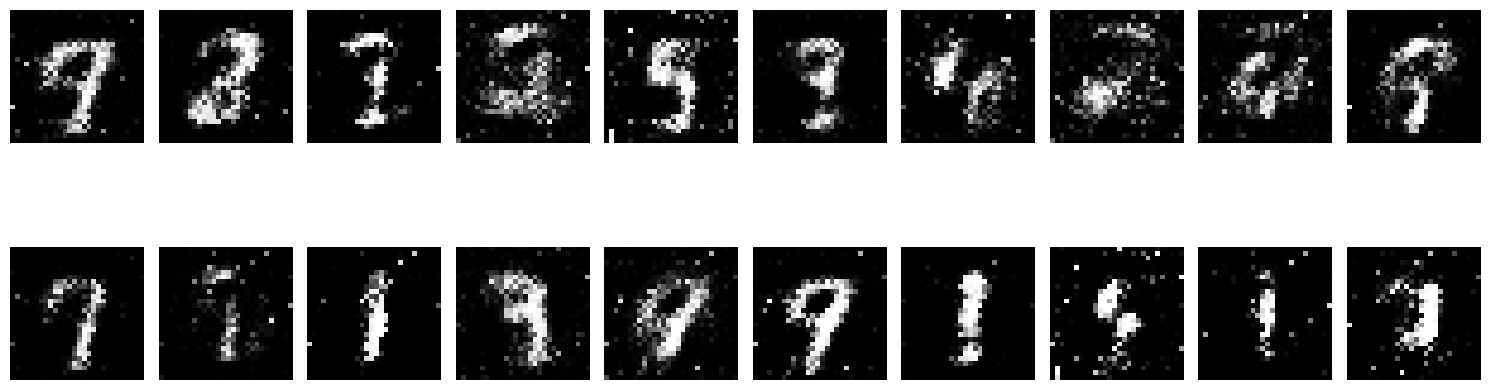

 57%|█████▊    | 230/400 [22:14<16:41,  5.89s/it]

231


 58%|█████▊    | 231/400 [22:20<16:22,  5.81s/it]

Epoch [231/400], D Loss: 0.2308, G Loss: 4.8020
232


 58%|█████▊    | 232/400 [22:26<16:32,  5.91s/it]

Epoch [232/400], D Loss: 0.2782, G Loss: 4.6010
233


 58%|█████▊    | 233/400 [22:32<16:06,  5.79s/it]

Epoch [233/400], D Loss: 0.2296, G Loss: 4.8384
234


 58%|█████▊    | 234/400 [22:37<15:46,  5.70s/it]

Epoch [234/400], D Loss: 0.2954, G Loss: 4.8203
235


 59%|█████▉    | 235/400 [22:43<15:31,  5.64s/it]

Epoch [235/400], D Loss: 0.3072, G Loss: 4.5332
236


 59%|█████▉    | 236/400 [22:48<15:15,  5.58s/it]

Epoch [236/400], D Loss: 0.3133, G Loss: 4.6537
237


 59%|█████▉    | 237/400 [22:53<15:03,  5.54s/it]

Epoch [237/400], D Loss: 0.2851, G Loss: 4.6143
238


 60%|█████▉    | 238/400 [22:59<15:16,  5.66s/it]

Epoch [238/400], D Loss: 0.2808, G Loss: 4.2822
239


 60%|█████▉    | 239/400 [23:05<14:59,  5.59s/it]

Epoch [239/400], D Loss: 0.2481, G Loss: 4.2320
240
Epoch [240/400], D Loss: 0.3343, G Loss: 3.9398


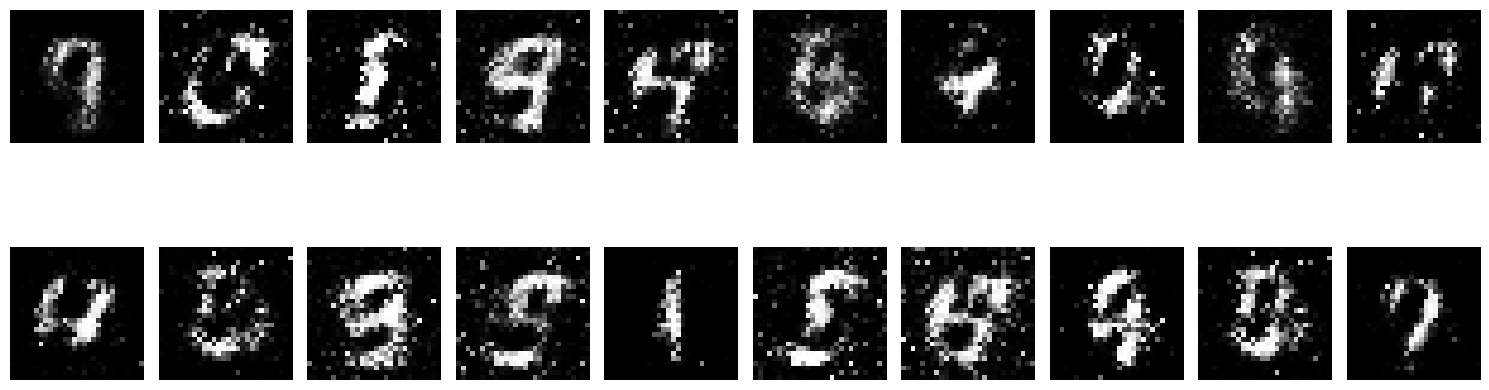

 60%|██████    | 240/400 [23:11<15:23,  5.77s/it]

241


 60%|██████    | 241/400 [23:16<15:04,  5.69s/it]

Epoch [241/400], D Loss: 0.2325, G Loss: 4.8636
242


 60%|██████    | 242/400 [23:22<14:52,  5.65s/it]

Epoch [242/400], D Loss: 0.3230, G Loss: 4.3355
243


 61%|██████    | 243/400 [23:28<14:56,  5.71s/it]

Epoch [243/400], D Loss: 0.2554, G Loss: 4.5129
244


 61%|██████    | 244/400 [23:34<14:46,  5.68s/it]

Epoch [244/400], D Loss: 0.2297, G Loss: 4.7490
245


 61%|██████▏   | 245/400 [23:39<14:35,  5.65s/it]

Epoch [245/400], D Loss: 0.2752, G Loss: 4.8969
246


 62%|██████▏   | 246/400 [23:45<14:25,  5.62s/it]

Epoch [246/400], D Loss: 0.2364, G Loss: 4.5494
247


 62%|██████▏   | 247/400 [23:50<14:13,  5.58s/it]

Epoch [247/400], D Loss: 0.2114, G Loss: 4.5096
248


 62%|██████▏   | 248/400 [23:56<14:06,  5.57s/it]

Epoch [248/400], D Loss: 0.2633, G Loss: 4.4674
249


 62%|██████▏   | 249/400 [24:02<14:19,  5.69s/it]

Epoch [249/400], D Loss: 0.2158, G Loss: 4.5916
250
Epoch [250/400], D Loss: 0.3230, G Loss: 4.3601


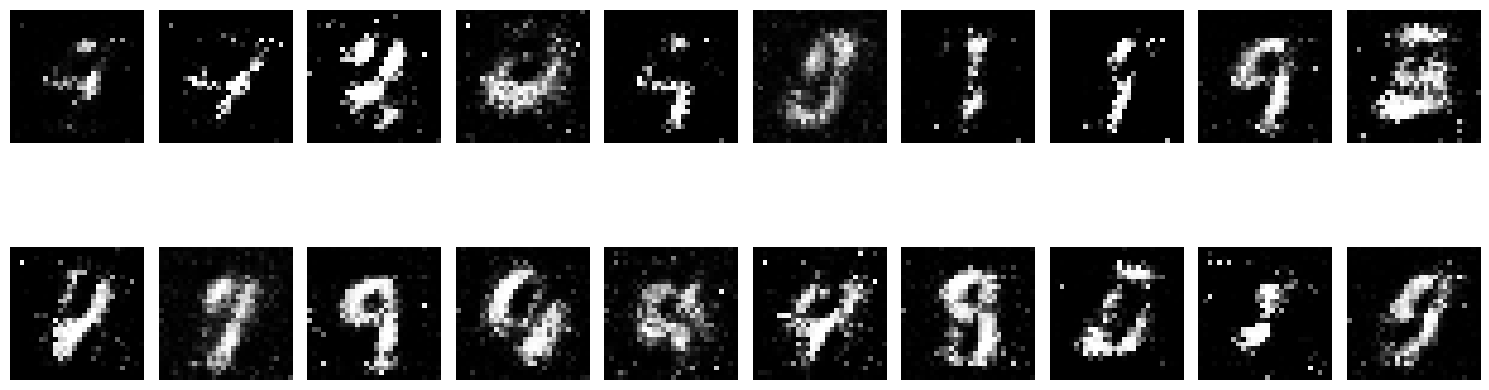

 62%|██████▎   | 250/400 [24:08<14:46,  5.91s/it]

251


 63%|██████▎   | 251/400 [24:14<14:20,  5.78s/it]

Epoch [251/400], D Loss: 0.2633, G Loss: 4.5201
252


 63%|██████▎   | 252/400 [24:19<14:03,  5.70s/it]

Epoch [252/400], D Loss: 0.2758, G Loss: 4.6353
253


 63%|██████▎   | 253/400 [24:25<13:51,  5.66s/it]

Epoch [253/400], D Loss: 0.2577, G Loss: 4.7156
254


 64%|██████▎   | 254/400 [24:30<13:39,  5.61s/it]

Epoch [254/400], D Loss: 0.3039, G Loss: 4.5259
255


 64%|██████▍   | 255/400 [24:36<13:54,  5.76s/it]

Epoch [255/400], D Loss: 0.2604, G Loss: 4.3037
256


 64%|██████▍   | 256/400 [24:42<13:40,  5.70s/it]

Epoch [256/400], D Loss: 0.2711, G Loss: 4.3409
257


 64%|██████▍   | 257/400 [24:47<13:28,  5.65s/it]

Epoch [257/400], D Loss: 0.2517, G Loss: 4.5096
258


 64%|██████▍   | 258/400 [24:53<13:14,  5.60s/it]

Epoch [258/400], D Loss: 0.2618, G Loss: 4.3620
259


 65%|██████▍   | 259/400 [24:58<13:06,  5.58s/it]

Epoch [259/400], D Loss: 0.2748, G Loss: 4.3442
260
Epoch [260/400], D Loss: 0.2542, G Loss: 4.3546


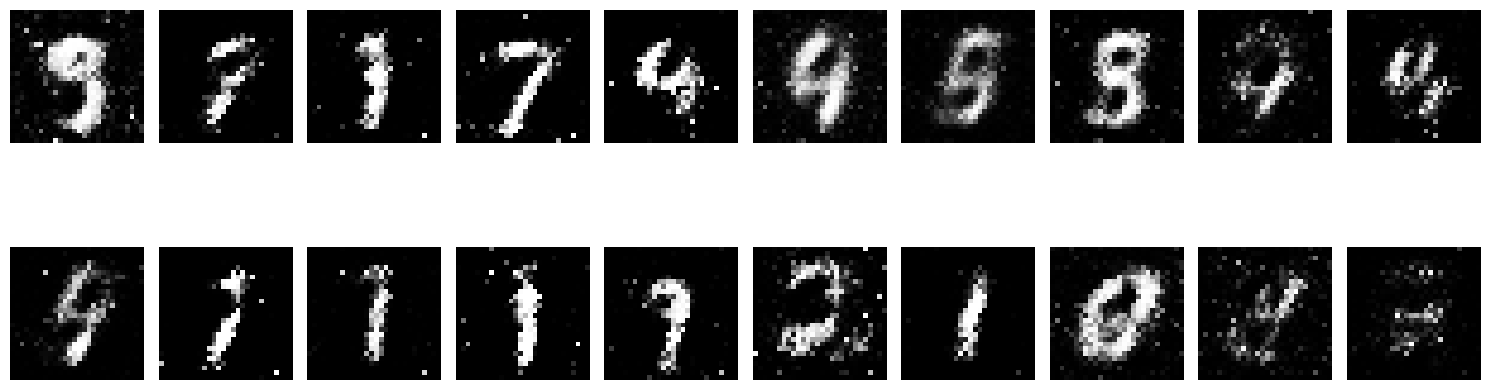

 65%|██████▌   | 260/400 [25:05<13:32,  5.80s/it]

261


 65%|██████▌   | 261/400 [25:10<13:17,  5.73s/it]

Epoch [261/400], D Loss: 0.3010, G Loss: 4.2879
262


 66%|██████▌   | 262/400 [25:16<13:04,  5.68s/it]

Epoch [262/400], D Loss: 0.2876, G Loss: 4.3915
263


 66%|██████▌   | 263/400 [25:21<12:52,  5.64s/it]

Epoch [263/400], D Loss: 0.3106, G Loss: 4.4812
264


 66%|██████▌   | 264/400 [25:27<12:39,  5.58s/it]

Epoch [264/400], D Loss: 0.3847, G Loss: 4.2356
265


 66%|██████▋   | 265/400 [25:32<12:26,  5.53s/it]

Epoch [265/400], D Loss: 0.3165, G Loss: 4.1661
266


 66%|██████▋   | 266/400 [25:38<12:37,  5.65s/it]

Epoch [266/400], D Loss: 0.3700, G Loss: 3.9871
267


 67%|██████▋   | 267/400 [25:44<12:23,  5.59s/it]

Epoch [267/400], D Loss: 0.2891, G Loss: 3.9910
268


 67%|██████▋   | 268/400 [25:49<12:14,  5.56s/it]

Epoch [268/400], D Loss: 0.3616, G Loss: 3.7497
269


 67%|██████▋   | 269/400 [25:55<12:06,  5.55s/it]

Epoch [269/400], D Loss: 0.3020, G Loss: 4.0038
270
Epoch [270/400], D Loss: 0.3061, G Loss: 3.9863


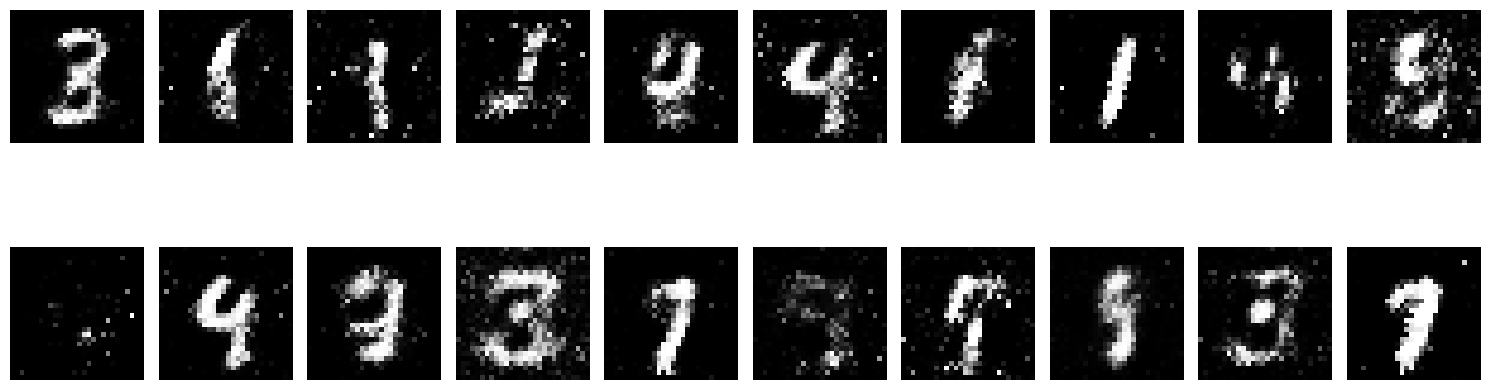

 68%|██████▊   | 270/400 [26:01<12:36,  5.82s/it]

271


 68%|██████▊   | 271/400 [26:07<12:23,  5.76s/it]

Epoch [271/400], D Loss: 0.3314, G Loss: 4.0850
272


 68%|██████▊   | 272/400 [26:13<12:24,  5.82s/it]

Epoch [272/400], D Loss: 0.3864, G Loss: 3.7879
273


 68%|██████▊   | 273/400 [26:18<12:19,  5.82s/it]

Epoch [273/400], D Loss: 0.3645, G Loss: 3.5608
274


 68%|██████▊   | 274/400 [26:24<12:12,  5.81s/it]

Epoch [274/400], D Loss: 0.3431, G Loss: 3.8115
275


 69%|██████▉   | 275/400 [26:30<12:03,  5.79s/it]

Epoch [275/400], D Loss: 0.3649, G Loss: 4.0548
276


 69%|██████▉   | 276/400 [26:36<11:49,  5.72s/it]

Epoch [276/400], D Loss: 0.4206, G Loss: 3.8812
277


 69%|██████▉   | 277/400 [26:41<11:42,  5.71s/it]

Epoch [277/400], D Loss: 0.3985, G Loss: 3.7152
278


 70%|██████▉   | 278/400 [26:47<11:39,  5.73s/it]

Epoch [278/400], D Loss: 0.3599, G Loss: 3.8598
279


 70%|██████▉   | 279/400 [26:52<11:23,  5.65s/it]

Epoch [279/400], D Loss: 0.3583, G Loss: 3.8693
280
Epoch [280/400], D Loss: 0.3215, G Loss: 3.9704


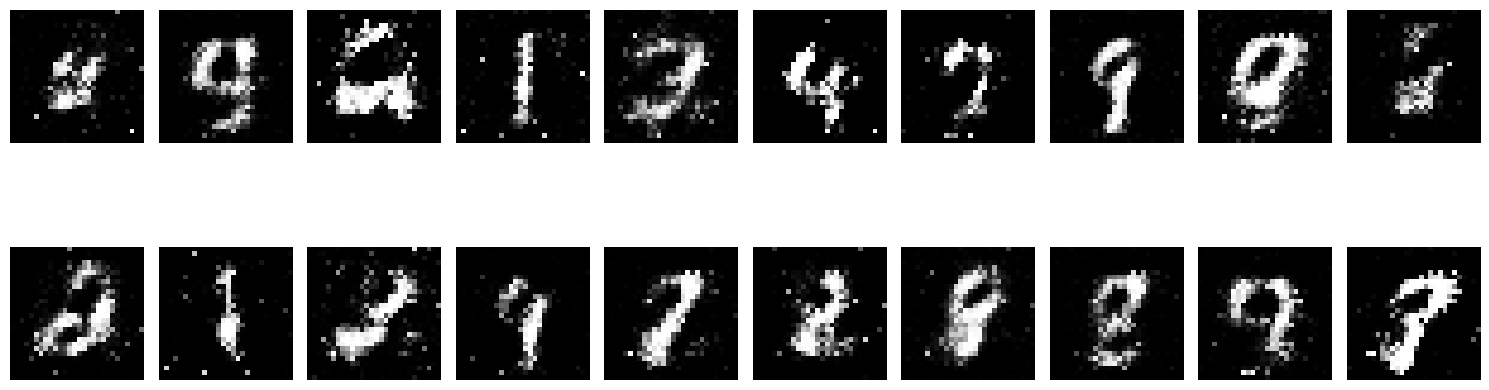

 70%|███████   | 280/400 [26:59<11:40,  5.84s/it]

281


 70%|███████   | 281/400 [27:04<11:24,  5.75s/it]

Epoch [281/400], D Loss: 0.3091, G Loss: 3.9982
282


 70%|███████   | 282/400 [27:10<11:14,  5.71s/it]

Epoch [282/400], D Loss: 0.3250, G Loss: 4.2880
283


 71%|███████   | 283/400 [27:16<11:19,  5.81s/it]

Epoch [283/400], D Loss: 0.3950, G Loss: 3.8827
284


 71%|███████   | 284/400 [27:22<11:05,  5.74s/it]

Epoch [284/400], D Loss: 0.3462, G Loss: 3.8111
285


 71%|███████▏  | 285/400 [27:27<10:56,  5.70s/it]

Epoch [285/400], D Loss: 0.4094, G Loss: 3.9556
286


 72%|███████▏  | 286/400 [27:33<10:41,  5.63s/it]

Epoch [286/400], D Loss: 0.3435, G Loss: 3.9293
287


 72%|███████▏  | 287/400 [27:38<10:31,  5.59s/it]

Epoch [287/400], D Loss: 0.4104, G Loss: 3.8749
288


 72%|███████▏  | 288/400 [27:44<10:23,  5.57s/it]

Epoch [288/400], D Loss: 0.3514, G Loss: 3.7378
289


 72%|███████▏  | 289/400 [27:50<10:31,  5.69s/it]

Epoch [289/400], D Loss: 0.3610, G Loss: 3.7999
290
Epoch [290/400], D Loss: 0.3944, G Loss: 3.7045


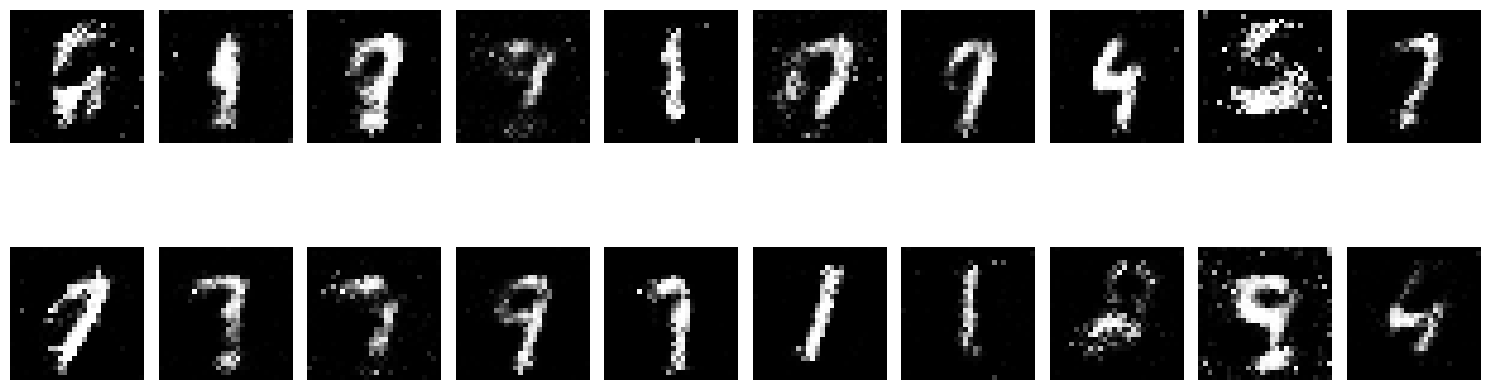

 72%|███████▎  | 290/400 [27:56<10:41,  5.83s/it]

291


 73%|███████▎  | 291/400 [28:02<10:38,  5.85s/it]

Epoch [291/400], D Loss: 0.4362, G Loss: 3.5655
292


 73%|███████▎  | 292/400 [28:08<10:36,  5.89s/it]

Epoch [292/400], D Loss: 0.3456, G Loss: 3.7552
293


 73%|███████▎  | 293/400 [28:14<10:34,  5.93s/it]

Epoch [293/400], D Loss: 0.4382, G Loss: 3.4163
294


 74%|███████▎  | 294/400 [28:20<10:45,  6.09s/it]

Epoch [294/400], D Loss: 0.3586, G Loss: 3.6058
295


 74%|███████▍  | 295/400 [28:26<10:35,  6.05s/it]

Epoch [295/400], D Loss: 0.4571, G Loss: 3.6106
296


 74%|███████▍  | 296/400 [28:32<10:24,  6.00s/it]

Epoch [296/400], D Loss: 0.4278, G Loss: 3.3178
297


 74%|███████▍  | 297/400 [28:38<10:14,  5.97s/it]

Epoch [297/400], D Loss: 0.4283, G Loss: 3.5453
298


 74%|███████▍  | 298/400 [28:44<10:07,  5.95s/it]

Epoch [298/400], D Loss: 0.4370, G Loss: 3.4921
299


 75%|███████▍  | 299/400 [28:50<10:02,  5.96s/it]

Epoch [299/400], D Loss: 0.4520, G Loss: 3.4803
300
Epoch [300/400], D Loss: 0.3956, G Loss: 3.5514


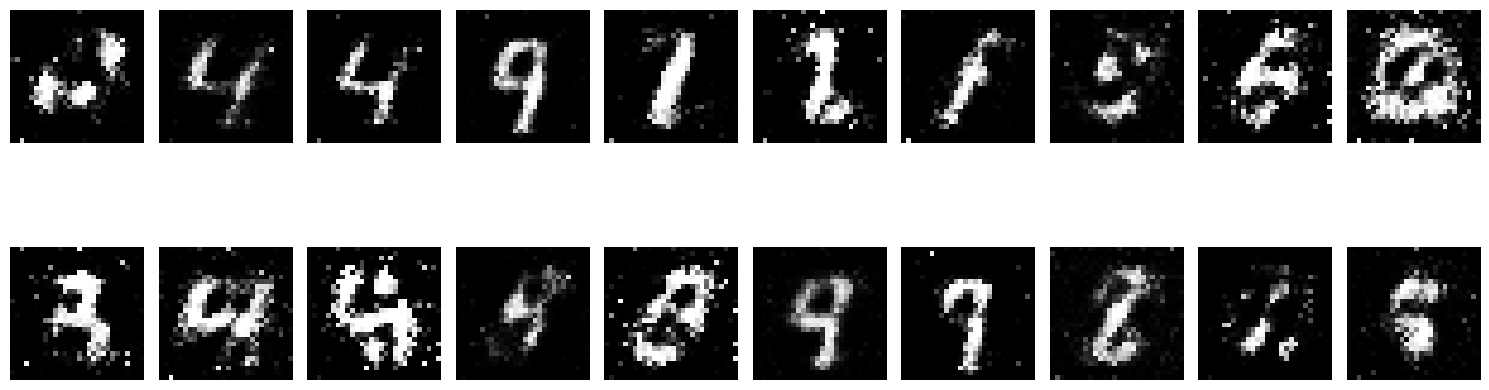

 75%|███████▌  | 300/400 [28:57<10:32,  6.33s/it]

301


 75%|███████▌  | 301/400 [29:03<10:03,  6.10s/it]

Epoch [301/400], D Loss: 0.4805, G Loss: 3.1854
302


 76%|███████▌  | 302/400 [29:08<09:41,  5.94s/it]

Epoch [302/400], D Loss: 0.4112, G Loss: 3.2365
303


 76%|███████▌  | 303/400 [29:14<09:24,  5.82s/it]

Epoch [303/400], D Loss: 0.4101, G Loss: 3.4337
304


 76%|███████▌  | 304/400 [29:19<09:11,  5.75s/it]

Epoch [304/400], D Loss: 0.3831, G Loss: 3.5052
305


 76%|███████▋  | 305/400 [29:25<09:15,  5.85s/it]

Epoch [305/400], D Loss: 0.4866, G Loss: 3.4830
306


 76%|███████▋  | 306/400 [29:31<08:57,  5.72s/it]

Epoch [306/400], D Loss: 0.4109, G Loss: 3.3419
307


 77%|███████▋  | 307/400 [29:36<08:49,  5.69s/it]

Epoch [307/400], D Loss: 0.4184, G Loss: 3.3238
308


 77%|███████▋  | 308/400 [29:42<08:35,  5.60s/it]

Epoch [308/400], D Loss: 0.4198, G Loss: 3.3321
309


 77%|███████▋  | 309/400 [29:47<08:27,  5.57s/it]

Epoch [309/400], D Loss: 0.4338, G Loss: 3.1796
310
Epoch [310/400], D Loss: 0.3916, G Loss: 3.2640


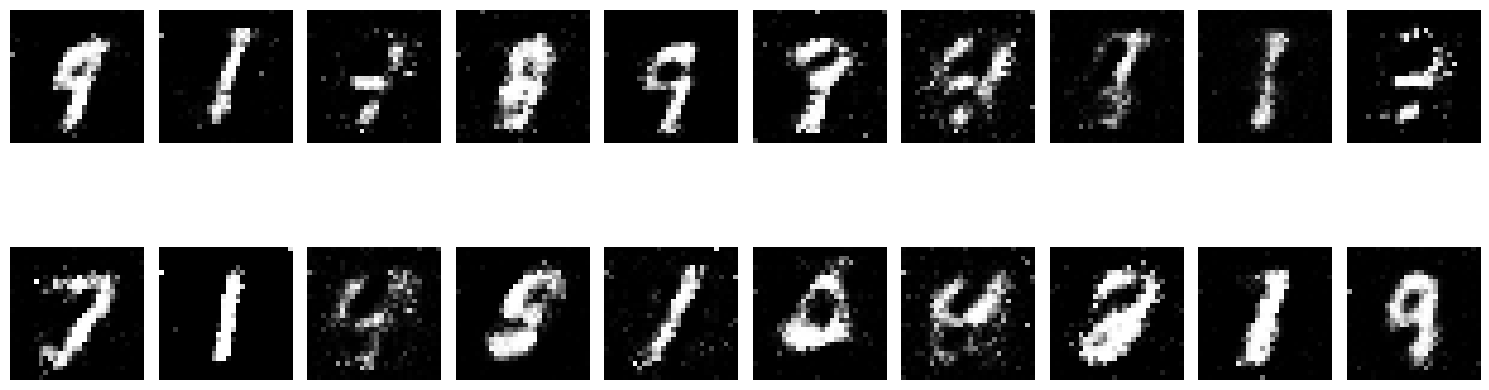

 78%|███████▊  | 310/400 [29:53<08:37,  5.75s/it]

311


 78%|███████▊  | 311/400 [30:00<08:47,  5.92s/it]

Epoch [311/400], D Loss: 0.4918, G Loss: 3.4542
312


 78%|███████▊  | 312/400 [30:06<08:39,  5.90s/it]

Epoch [312/400], D Loss: 0.4992, G Loss: 3.3553
313


 78%|███████▊  | 313/400 [30:12<08:34,  5.92s/it]

Epoch [313/400], D Loss: 0.4547, G Loss: 3.3870
314


 78%|███████▊  | 314/400 [30:17<08:27,  5.90s/it]

Epoch [314/400], D Loss: 0.4229, G Loss: 3.1203
315


 79%|███████▉  | 315/400 [30:23<08:22,  5.91s/it]

Epoch [315/400], D Loss: 0.4451, G Loss: 3.2066
316


 79%|███████▉  | 316/400 [30:30<08:27,  6.04s/it]

Epoch [316/400], D Loss: 0.4512, G Loss: 3.3173
317


 79%|███████▉  | 317/400 [30:35<08:15,  5.97s/it]

Epoch [317/400], D Loss: 0.4716, G Loss: 3.2473
318


 80%|███████▉  | 318/400 [30:41<08:05,  5.93s/it]

Epoch [318/400], D Loss: 0.4919, G Loss: 3.1439
319


 80%|███████▉  | 319/400 [30:47<07:59,  5.92s/it]

Epoch [319/400], D Loss: 0.4883, G Loss: 3.0992
320
Epoch [320/400], D Loss: 0.5062, G Loss: 3.2784


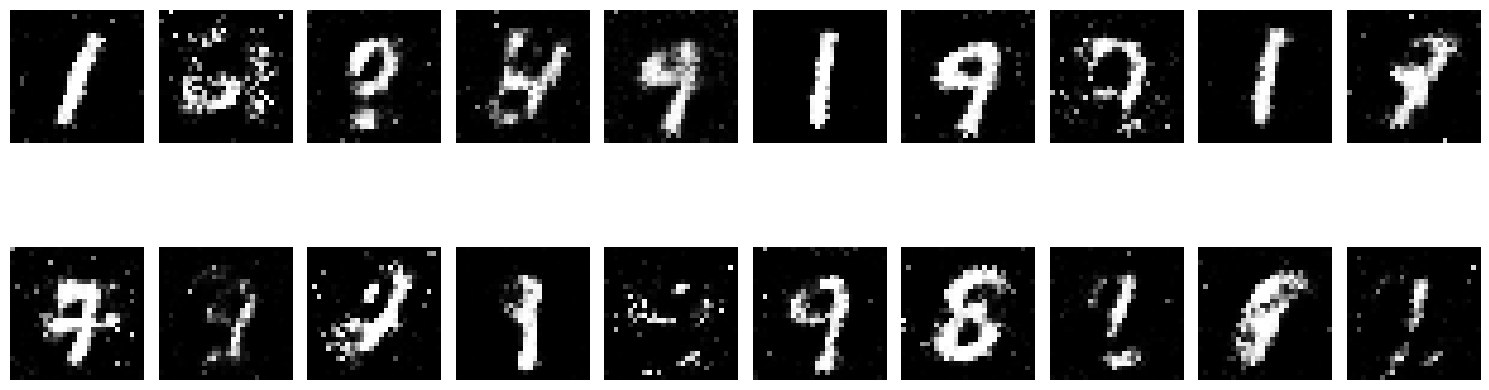

 80%|████████  | 320/400 [30:54<08:13,  6.17s/it]

321


 80%|████████  | 321/400 [31:00<07:55,  6.02s/it]

Epoch [321/400], D Loss: 0.4967, G Loss: 3.0805
322


 80%|████████  | 322/400 [31:05<07:43,  5.94s/it]

Epoch [322/400], D Loss: 0.4957, G Loss: 3.0096
323


 81%|████████  | 323/400 [31:11<07:25,  5.79s/it]

Epoch [323/400], D Loss: 0.4852, G Loss: 3.1287
324


 81%|████████  | 324/400 [31:16<07:13,  5.70s/it]

Epoch [324/400], D Loss: 0.5352, G Loss: 3.0101
325


 81%|████████▏ | 325/400 [31:22<07:04,  5.66s/it]

Epoch [325/400], D Loss: 0.4453, G Loss: 3.2569
326


 82%|████████▏ | 326/400 [31:27<06:56,  5.62s/it]

Epoch [326/400], D Loss: 0.4939, G Loss: 3.2163
327


 82%|████████▏ | 327/400 [31:33<06:57,  5.73s/it]

Epoch [327/400], D Loss: 0.5122, G Loss: 3.0137
328


 82%|████████▏ | 328/400 [31:39<06:48,  5.67s/it]

Epoch [328/400], D Loss: 0.4611, G Loss: 2.9643
329


 82%|████████▏ | 329/400 [31:44<06:38,  5.61s/it]

Epoch [329/400], D Loss: 0.4774, G Loss: 3.0605
330
Epoch [330/400], D Loss: 0.4658, G Loss: 3.1614


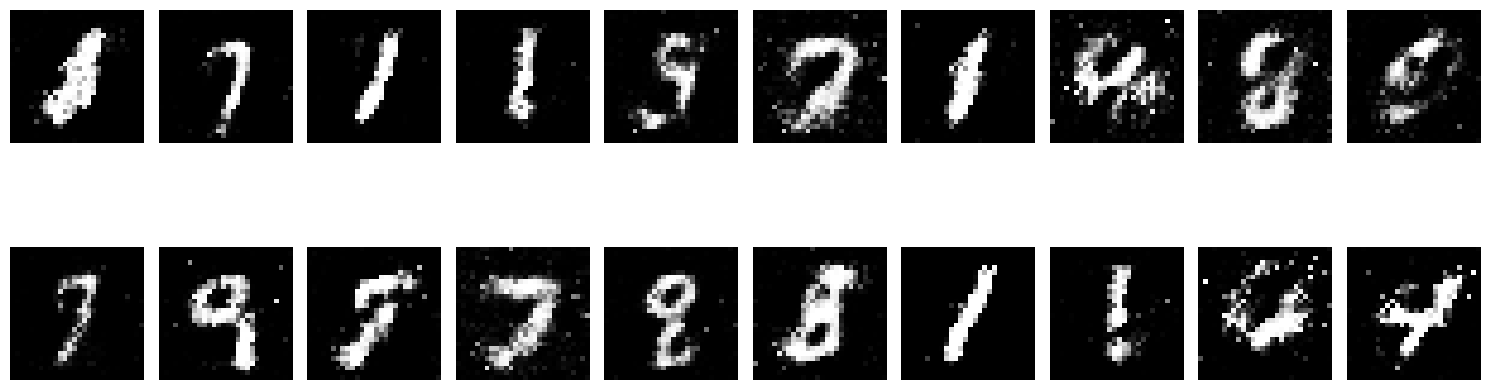

 82%|████████▎ | 330/400 [31:51<06:47,  5.82s/it]

331


 83%|████████▎ | 331/400 [31:56<06:34,  5.72s/it]

Epoch [331/400], D Loss: 0.5243, G Loss: 2.9278
332


 83%|████████▎ | 332/400 [32:02<06:24,  5.65s/it]

Epoch [332/400], D Loss: 0.4438, G Loss: 3.0487
333


 83%|████████▎ | 333/400 [32:08<06:25,  5.76s/it]

Epoch [333/400], D Loss: 0.5044, G Loss: 3.0640
334


 84%|████████▎ | 334/400 [32:13<06:14,  5.67s/it]

Epoch [334/400], D Loss: 0.4161, G Loss: 3.1479
335


 84%|████████▍ | 335/400 [32:19<06:05,  5.63s/it]

Epoch [335/400], D Loss: 0.5484, G Loss: 3.1359
336


 84%|████████▍ | 336/400 [32:24<05:58,  5.61s/it]

Epoch [336/400], D Loss: 0.4527, G Loss: 3.0471
337


 84%|████████▍ | 337/400 [32:30<05:50,  5.57s/it]

Epoch [337/400], D Loss: 0.5329, G Loss: 2.7379
338


 84%|████████▍ | 338/400 [32:35<05:43,  5.53s/it]

Epoch [338/400], D Loss: 0.5236, G Loss: 2.9531
339


 85%|████████▍ | 339/400 [32:41<05:46,  5.67s/it]

Epoch [339/400], D Loss: 0.4925, G Loss: 2.9351
340
Epoch [340/400], D Loss: 0.5230, G Loss: 3.0222


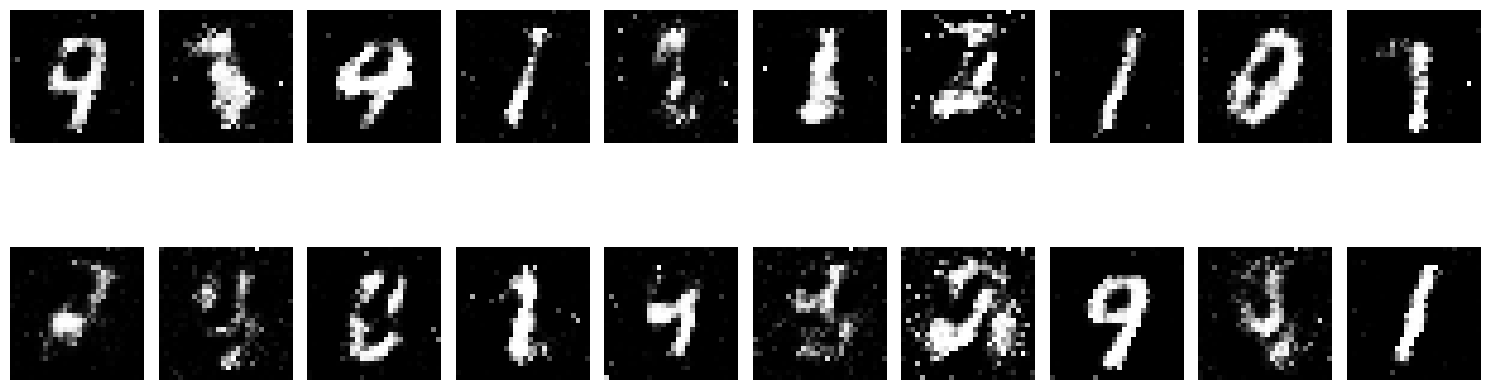

 85%|████████▌ | 340/400 [32:48<05:54,  5.91s/it]

341


 85%|████████▌ | 341/400 [32:53<05:39,  5.75s/it]

Epoch [341/400], D Loss: 0.4826, G Loss: 2.9915
342


 86%|████████▌ | 342/400 [32:58<05:29,  5.68s/it]

Epoch [342/400], D Loss: 0.4655, G Loss: 2.9774
343


 86%|████████▌ | 343/400 [33:04<05:19,  5.60s/it]

Epoch [343/400], D Loss: 0.5035, G Loss: 3.0254
344


 86%|████████▌ | 344/400 [33:10<05:16,  5.65s/it]

Epoch [344/400], D Loss: 0.5144, G Loss: 3.0610
345


 86%|████████▋ | 345/400 [33:15<05:09,  5.62s/it]

Epoch [345/400], D Loss: 0.4997, G Loss: 3.0001
346


 86%|████████▋ | 346/400 [33:21<05:00,  5.56s/it]

Epoch [346/400], D Loss: 0.5120, G Loss: 3.0801
347


 87%|████████▋ | 347/400 [33:26<04:54,  5.55s/it]

Epoch [347/400], D Loss: 0.4910, G Loss: 2.9213
348


 87%|████████▋ | 348/400 [33:32<04:46,  5.51s/it]

Epoch [348/400], D Loss: 0.4961, G Loss: 3.0381
349


 87%|████████▋ | 349/400 [33:37<04:40,  5.50s/it]

Epoch [349/400], D Loss: 0.5002, G Loss: 2.9883
350
Epoch [350/400], D Loss: 0.5875, G Loss: 3.0740


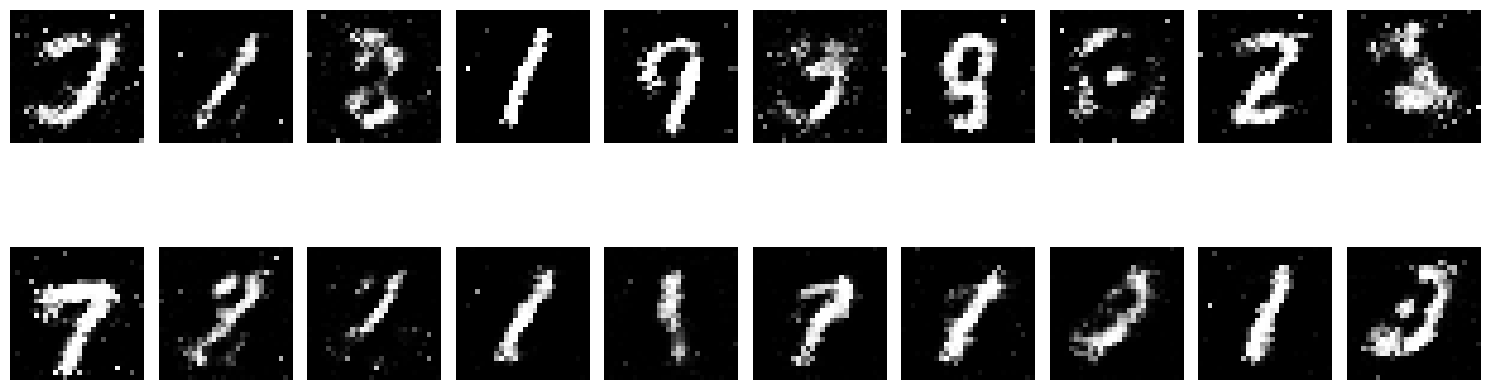

 88%|████████▊ | 350/400 [33:44<04:52,  5.85s/it]

351


 88%|████████▊ | 351/400 [33:49<04:41,  5.74s/it]

Epoch [351/400], D Loss: 0.5103, G Loss: 2.8791
352


 88%|████████▊ | 352/400 [33:55<04:30,  5.63s/it]

Epoch [352/400], D Loss: 0.5841, G Loss: 2.8347
353


 88%|████████▊ | 353/400 [34:00<04:22,  5.59s/it]

Epoch [353/400], D Loss: 0.5207, G Loss: 2.8932
354


 88%|████████▊ | 354/400 [34:06<04:15,  5.55s/it]

Epoch [354/400], D Loss: 0.5158, G Loss: 2.9252
355


 89%|████████▉ | 355/400 [34:11<04:07,  5.49s/it]

Epoch [355/400], D Loss: 0.5388, G Loss: 2.6829
356


 89%|████████▉ | 356/400 [34:17<04:07,  5.63s/it]

Epoch [356/400], D Loss: 0.5124, G Loss: 2.7316
357


 89%|████████▉ | 357/400 [34:22<03:59,  5.58s/it]

Epoch [357/400], D Loss: 0.5151, G Loss: 2.8655
358


 90%|████████▉ | 358/400 [34:28<03:52,  5.55s/it]

Epoch [358/400], D Loss: 0.5593, G Loss: 2.7243
359


 90%|████████▉ | 359/400 [34:33<03:45,  5.51s/it]

Epoch [359/400], D Loss: 0.5411, G Loss: 2.8441
360
Epoch [360/400], D Loss: 0.5685, G Loss: 2.8273


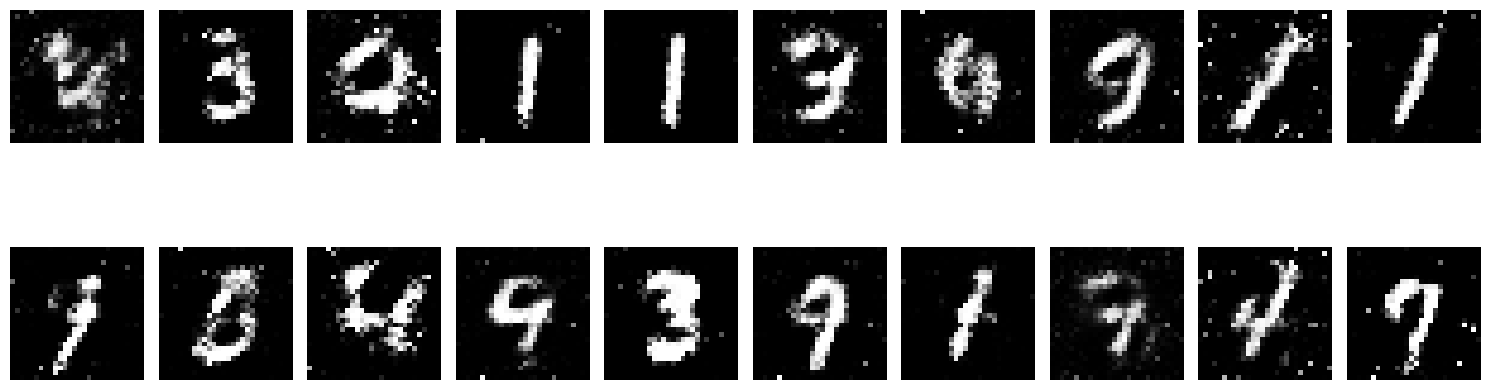

 90%|█████████ | 360/400 [34:40<03:50,  5.77s/it]

361


 90%|█████████ | 361/400 [34:45<03:40,  5.67s/it]

Epoch [361/400], D Loss: 0.4845, G Loss: 2.9321
362


 90%|█████████ | 362/400 [34:51<03:37,  5.73s/it]

Epoch [362/400], D Loss: 0.5429, G Loss: 2.7314
363


 91%|█████████ | 363/400 [34:56<03:28,  5.65s/it]

Epoch [363/400], D Loss: 0.5057, G Loss: 2.9353
364


 91%|█████████ | 364/400 [35:02<03:20,  5.57s/it]

Epoch [364/400], D Loss: 0.5659, G Loss: 2.8250
365


 91%|█████████▏| 365/400 [35:07<03:13,  5.54s/it]

Epoch [365/400], D Loss: 0.5817, G Loss: 2.9010
366


 92%|█████████▏| 366/400 [35:13<03:07,  5.51s/it]

Epoch [366/400], D Loss: 0.5249, G Loss: 2.7479
367


 92%|█████████▏| 367/400 [35:18<03:03,  5.56s/it]

Epoch [367/400], D Loss: 0.5606, G Loss: 2.7116
368


 92%|█████████▏| 368/400 [35:24<02:59,  5.60s/it]

Epoch [368/400], D Loss: 0.5414, G Loss: 2.8610
369


 92%|█████████▏| 369/400 [35:30<02:52,  5.58s/it]

Epoch [369/400], D Loss: 0.5807, G Loss: 2.9002
370
Epoch [370/400], D Loss: 0.5421, G Loss: 2.8100


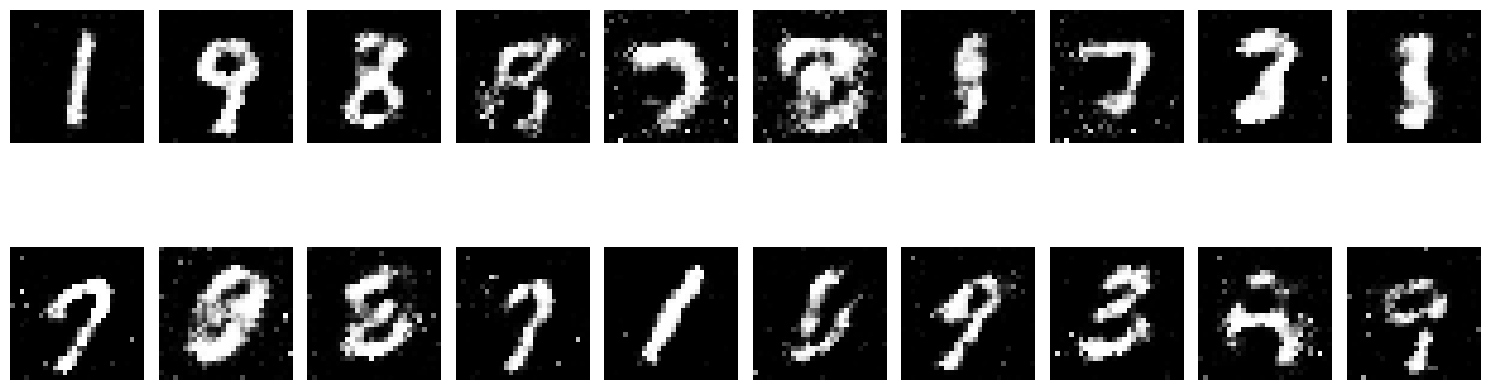

 92%|█████████▎| 370/400 [35:36<02:53,  5.78s/it]

371


 93%|█████████▎| 371/400 [35:41<02:44,  5.66s/it]

Epoch [371/400], D Loss: 0.5403, G Loss: 2.7343
372


 93%|█████████▎| 372/400 [35:47<02:37,  5.64s/it]

Epoch [372/400], D Loss: 0.5365, G Loss: 2.7442
373


 93%|█████████▎| 373/400 [35:53<02:34,  5.71s/it]

Epoch [373/400], D Loss: 0.5873, G Loss: 2.7635
374


 94%|█████████▎| 374/400 [35:58<02:26,  5.64s/it]

Epoch [374/400], D Loss: 0.5244, G Loss: 2.7684
375


 94%|█████████▍| 375/400 [36:03<02:18,  5.56s/it]

Epoch [375/400], D Loss: 0.5342, G Loss: 2.7662
376


 94%|█████████▍| 376/400 [36:09<02:12,  5.53s/it]

Epoch [376/400], D Loss: 0.5876, G Loss: 2.7280
377


 94%|█████████▍| 377/400 [36:14<02:06,  5.48s/it]

Epoch [377/400], D Loss: 0.5314, G Loss: 2.8452
378


 94%|█████████▍| 378/400 [36:20<02:00,  5.50s/it]

Epoch [378/400], D Loss: 0.5500, G Loss: 2.8409
379


 95%|█████████▍| 379/400 [36:26<01:59,  5.67s/it]

Epoch [379/400], D Loss: 0.5763, G Loss: 2.7488
380
Epoch [380/400], D Loss: 0.5856, G Loss: 2.7104


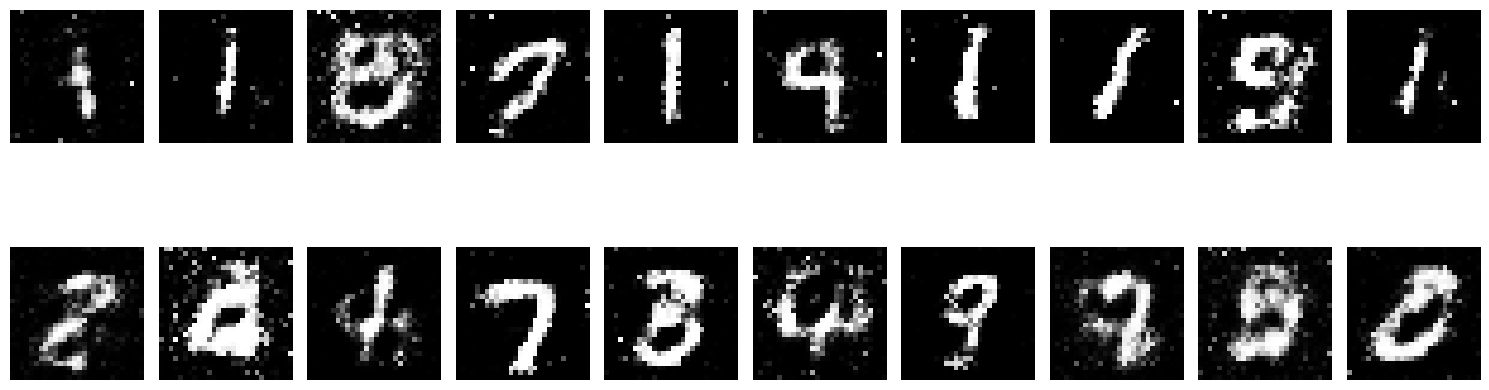

 95%|█████████▌| 380/400 [36:32<01:58,  5.91s/it]

381


 95%|█████████▌| 381/400 [36:38<01:50,  5.81s/it]

Epoch [381/400], D Loss: 0.5983, G Loss: 2.8139
382


 96%|█████████▌| 382/400 [36:43<01:43,  5.73s/it]

Epoch [382/400], D Loss: 0.5352, G Loss: 2.7596
383


 96%|█████████▌| 383/400 [36:49<01:36,  5.68s/it]

Epoch [383/400], D Loss: 0.5608, G Loss: 2.6513
384


 96%|█████████▌| 384/400 [36:55<01:30,  5.65s/it]

Epoch [384/400], D Loss: 0.5816, G Loss: 2.6024
385


 96%|█████████▋| 385/400 [37:01<01:26,  5.74s/it]

Epoch [385/400], D Loss: 0.5493, G Loss: 2.8036
386


 96%|█████████▋| 386/400 [37:06<01:19,  5.68s/it]

Epoch [386/400], D Loss: 0.5839, G Loss: 2.6209
387


 97%|█████████▋| 387/400 [37:12<01:13,  5.64s/it]

Epoch [387/400], D Loss: 0.5508, G Loss: 2.7682
388


 97%|█████████▋| 388/400 [37:17<01:07,  5.60s/it]

Epoch [388/400], D Loss: 0.5657, G Loss: 2.6008
389


 97%|█████████▋| 389/400 [37:23<01:01,  5.61s/it]

Epoch [389/400], D Loss: 0.5753, G Loss: 2.6179
390
Epoch [390/400], D Loss: 0.5662, G Loss: 2.7566


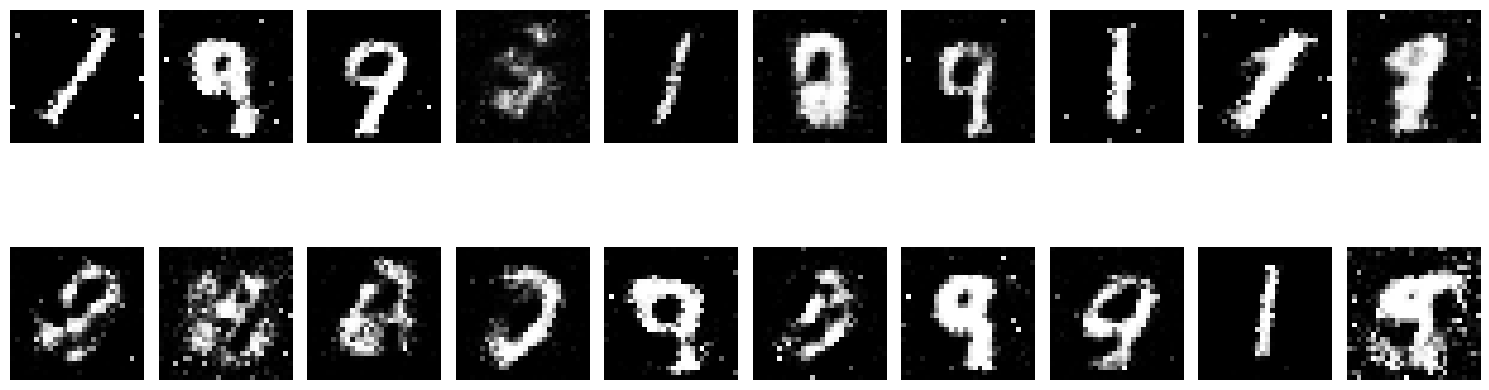

 98%|█████████▊| 390/400 [37:29<00:58,  5.90s/it]

391


 98%|█████████▊| 391/400 [37:35<00:51,  5.77s/it]

Epoch [391/400], D Loss: 0.5278, G Loss: 2.8196
392


 98%|█████████▊| 392/400 [37:40<00:45,  5.71s/it]

Epoch [392/400], D Loss: 0.5637, G Loss: 2.7647
393


 98%|█████████▊| 393/400 [37:46<00:39,  5.67s/it]

Epoch [393/400], D Loss: 0.5768, G Loss: 2.7266
394


 98%|█████████▊| 394/400 [37:52<00:33,  5.66s/it]

Epoch [394/400], D Loss: 0.5637, G Loss: 2.7799
395


 99%|█████████▉| 395/400 [37:57<00:28,  5.65s/it]

Epoch [395/400], D Loss: 0.5649, G Loss: 2.7851
396


 99%|█████████▉| 396/400 [38:03<00:23,  5.77s/it]

Epoch [396/400], D Loss: 0.5666, G Loss: 2.7820
397


 99%|█████████▉| 397/400 [38:09<00:17,  5.69s/it]

Epoch [397/400], D Loss: 0.5745, G Loss: 2.7556
398


100%|█████████▉| 398/400 [38:14<00:11,  5.62s/it]

Epoch [398/400], D Loss: 0.5968, G Loss: 2.6465
399


100%|█████████▉| 399/400 [38:20<00:05,  5.60s/it]

Epoch [399/400], D Loss: 0.5812, G Loss: 2.6597
400
Epoch [400/400], D Loss: 0.5710, G Loss: 2.6825


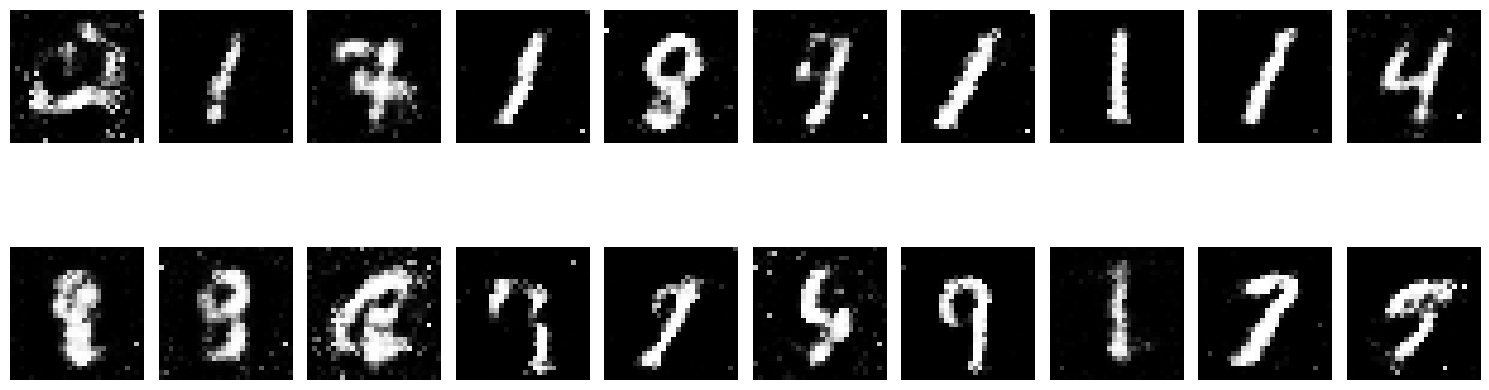

100%|██████████| 400/400 [38:26<00:00,  5.77s/it]


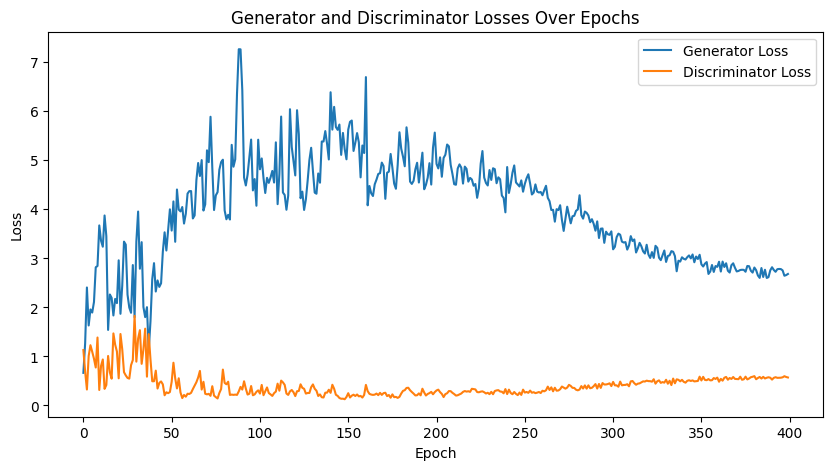

Training done


In [9]:
import torch
import os
from tqdm import trange
import argparse
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from model import Generator, Discriminator
from utils import D_train, G_train, save_models
from IPython.display import display 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parser = argparse.ArgumentParser(description='Train Normalizing Flow.')
parser.add_argument("--epochs", type=int, default=400, help="Number of epochs for training.")
parser.add_argument("--lr", type=float, default=0.0001, help="The learning rate to use for training.")
parser.add_argument("--batch_size", type=int, default=1024, help="Size of mini-batches for SGD")
args = parser.parse_args(args=[])

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Dataset loading...')
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/MNIST/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)
print('Dataset Loaded.')

print('Model Loading...')
mnist_dim = 784
G = torch.nn.DataParallel(Generator(g_output_dim=mnist_dim)).to(device)
D = torch.nn.DataParallel(Discriminator(mnist_dim)).to(device)
print('Model loaded.')

criterion = nn.BCELoss().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=args.lr)
D_optimizer = optim.Adam(D.parameters(), lr=args.lr)

print('Start Training:')

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_losses):
    """Function to plot the losses over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Initialize lists to store the losses
G_losses = []
D_losses = []

n_epoch = args.epochs
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [10]:
!ls checkpoints

D.pth  G.pth


In [11]:
def save_models(generator, discriminator, epoch, g_losses, d_losses, path='checkpoints'):
    checkpoint = {
        'epoch': epoch,
        'G_state_dict': generator.state_dict(),
        'D_state_dict': discriminator.state_dict(),
        'G_optimizer_state_dict': G_optimizer.state_dict(),
        'D_optimizer_state_dict': D_optimizer.state_dict(),
        'G_losses': g_losses,
        'D_losses': d_losses
    }
    torch.save(checkpoint, os.path.join(path, 'model_checkpoint.pth'))


In [12]:
save_models(generator, discriminator, epoch, g_losses, d_losses)

NameError: name 'generator' is not defined

In [ ]:
def load_checkpoint(generator, discriminator, g_optimizer, d_optimizer, path='checkpoints/model_checkpoint.pth'):
    checkpoint = torch.load(path)
    generator.load_state_dict(checkpoint['G_state_dict'])
    discriminator.load_state_dict(checkpoint['D_state_dict'])
    g_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    g_losses = checkpoint['G_losses']
    d_losses = checkpoint['D_losses']
    return start_epoch, g_losses, d_losses


In [ ]:
# Check if a checkpoint exists to resume from
checkpoint_path = 'checkpoints/model_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, G_losses, D_losses = load_checkpoint(G, D, G_optimizer, D_optimizer, checkpoint_path)
    print(f"Resuming from epoch {start_epoch}")

In [ ]:
n_epoch=30
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [ ]:
torch.save(G.state_dict(), 'generator2.pth')

In [1]:
!pip install torch torchvision tqdm matplotlib

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, dim_latent=100, num_class=10):
        super(Generator, self).__init__()

        self.dim_latent = dim_latent
        self.use_class = num_class > 0

        if self.use_class:
            self.emb_class = nn.Embedding(num_class, dim_latent)
            self.fc = nn.Linear(dim_latent * 2, 512 * 3 * 3)
        else:
            self.fc = nn.Linear(dim_latent, 512 * 3 * 3)

        self.g_function = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=6, stride=2),
            nn.Sigmoid()
            )

    def forward(self, x, class_ids):
        batch_size = x.size(0)

        if self.use_class:
            x_class = self.emb_class(class_ids)
            x = self.fc(torch.cat((x, x_class), dim=1))
        else:
            x = self.fc(x)

        x = F.leaky_relu(x)
        x = x.view(batch_size, 512, 3, 3)
        img = self.g_function(x)

        return img


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BaseDiscriminator(nn.Module):
    def __init__(self, num_class=10):
        super(BaseDiscriminator, self).__init__()

        # Feature extractor
        self.h_function = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=6, stride=2),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(
                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2)
            )

        # Last linear layer
        self.use_class = num_class > 0
        self.fc_w = nn.Parameter(
            torch.randn(num_class if self.use_class else 1, 512 * 3 * 3))

    def forward(self, x, class_ids, flg_train: bool):
        h_feature = self.h_function(x)
        h_feature = torch.flatten(h_feature, start_dim=1)
        weights = self.fc_w[class_ids] if self.use_class else self.fc_w
        out = (h_feature * weights).sum(dim=1)

        return out


# Modified Discriminator Architecture

class SanDiscriminator(BaseDiscriminator):
    def __init__(self, num_class=10):
        super(SanDiscriminator, self).__init__(num_class)

    def forward(self, x, class_ids, flg_train: bool):
        h_feature = self.h_function(x)
        h_feature = torch.flatten(h_feature, start_dim=1)
        weights = self.fc_w[class_ids] if self.use_class else self.fc_w
        direction = F.normalize(weights, dim=1) # Normalize the last layer
        scale = torch.norm(weights, dim=1).unsqueeze(1)
        h_feature = h_feature * scale # For keep the scale
        if flg_train: # for discriminator training
            out_fun = (h_feature * direction.detach()).sum(dim=1)
            out_dir = (h_feature.detach() * direction).sum(dim=1)
            out = dict(fun=out_fun, dir=out_dir)
        else: # for generator training or inference
            out = (h_feature * direction).sum(dim=1)

        return out

In [13]:
import argparse
import json
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader

In [23]:
import os
import json

# Define folder paths
mnist_folder = './data/MNIST'
logs_folder = './logs'
params_path = './hparams/params.json'

# Create folders if they don't exist
os.makedirs(mnist_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)
os.makedirs(os.path.dirname(params_path), exist_ok=True)

# Define the parameters for params.json
params = {
    "dim_latent": 100,
    "batch_size": 128,
    "learning_rate": 0.001,
    "beta_1": 0.0,
    "beta_2": 0.99,
    "num_epochs": 2
}

# Write parameters to params.json
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Created folders '{mnist_folder}' and '{logs_folder}', and saved parameters to '{params_path}'.")


Created folders './data/MNIST' and './logs', and saved parameters to './hparams/params.json'.


In [24]:
default_args = {
    "datadir": "./data/MNIST",
    "params": "./hparams/params.json",
    "model": "gan",
    "enable_class": False,
    "logdir": "./logs",
    "device": 0
}


In [25]:
from argparse import Namespace
args = Namespace(**default_args)

print(args.datadir)        # Access './data/MNIST'
print(args.params)         # Access './hparams/params.json'
print(args.model)          # Access 'gan'
print(args.enable_class)   # Access False
print(args.logdir)         # Access './logs'
print(args.device)         # Access 0

./data/MNIST
./hparams/params.json
gan
False
./logs
0


In [21]:
# Train functions

def update_discriminator(x, class_ids, discriminator, generator, optimizer, params):
    bs = x.size(0)
    device = x.device

    optimizer.zero_grad()

    # for data (ground-truth) distribution
    disc_real = discriminator(x, class_ids, flg_train=True)
    loss_real = eval('compute_loss_'+args.model)(disc_real, loss_type='real')

    # for generator distribution
    latent = torch.randn(bs, params["dim_latent"], device=device)
    img_fake = generator(latent, class_ids)
    disc_fake = discriminator(img_fake.detach(), class_ids, flg_train=True)
    loss_fake = eval('compute_loss_'+args.model)(disc_fake, loss_type='fake')


    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer.step()


def update_generator(num_class, discriminator, generator, optimizer, params, device):
    optimizer.zero_grad()

    bs = params['batch_size']
    latent = torch.randn(bs, params["dim_latent"], device=device)

    class_ids = torch.randint(num_class, size=(bs,), device=device)
    batch_fake = generator(latent, class_ids)

    disc_gen = discriminator(batch_fake, class_ids, flg_train=False)
    loss_g = - disc_gen.mean()
    loss_g.backward()
    optimizer.step()


def compute_loss_gan(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss = (1. - disc).relu().mean() # Hinge loss
    else: # 'fake' == loss_type
        loss = (1. + disc).relu().mean() # Hinge loss

    return loss


def compute_loss_san(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss_fun = (1. - disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = - disc['dir'].mean() # Wasserstein loss for omega
    else: # 'fake' == loss_type
        loss_fun = (1. + disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = disc['dir'].mean() # Wasserstein loss for omega
    loss = loss_fun + loss_dir

    return loss


def save_images(imgs, idx, dirname='test'):
    import numpy as np
    if imgs.shape[1] == 1:
        imgs = np.repeat(imgs, 3, axis=1)
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.transpose((1,2,0)))

    if not os.path.exists('out/{}/'.format(dirname)):
        os.makedirs('out/{}/'.format(dirname))
    plt.savefig('out/{0}/{1}.png'.format(dirname, str(idx).zfill(3)), bbox_inches="tight")
    plt.close(fig)

In [26]:
device = f'cuda:{args.device}' if args.device is not None else 'cpu'
model_name = args.model
if not model_name in ['gan', 'san']:
    raise RuntimeError("A model name have to be 'gan' or 'san'.")
    
experiment_name = model_name + "_cond" if args.enable_class else model_name

# dataloading
num_class = 10
train_dataset = datasets.MNIST(root=args.datadir, transform=transforms.ToTensor(), train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], num_workers=4,
                          pin_memory=True, persistent_workers=True, shuffle=True)
test_dataset = datasets.MNIST(root=args.datadir, transform=transforms.ToTensor(), train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], num_workers=4,
                         pin_memory=True, persistent_workers=True, shuffle=False)

# model
use_class = args.enable_class
generator = Generator(params["dim_latent"], num_class=num_class if use_class else 0)
if 'gan' == args.model:
    discriminator = BaseDiscriminator(num_class=num_class if use_class else 0)
else: # 'san' == args.model
    discriminator = SanDiscriminator(num_class=num_class if use_class else 0)
generator = generator.to(device)
discriminator = discriminator.to(device)

# optimizer
betas = (params["beta_1"], params["beta_2"])
optimizer_G = optim.Adam(generator.parameters(), lr=params["learning_rate"], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=params["learning_rate"], betas=betas)

ckpt_dir = f'{args.logdir}/{experiment_name}/'
if not os.path.exists(args.logdir):
    os.mkdir(args.logdir)
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

steps_per_epoch = len(train_loader)

msg = ["\t{0}: {1}".format(key, val) for key, val in params.items()]
print("hyperparameters: \n" + "\n".join(msg))

# eval initial states
num_samples_per_class = 10
with torch.no_grad():
    latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
    class_ids = torch.arange(num_class, dtype=torch.long,
                             device=device).repeat_interleave(num_samples_per_class)
    imgs_fake = generator(latent, class_ids)

# main training loop
for n in range(params["num_epochs"]):
    loader = iter(train_loader)

    print("epoch: {0}/{1}".format(n + 1, params["num_epochs"]))
    for i in tqdm.trange(steps_per_epoch):
        x, class_ids = next(loader)
        x = x.to(device)
        class_ids = class_ids.to(device)

        update_discriminator(x, class_ids, discriminator, generator, optimizer_D, params)
        update_generator(num_class, discriminator, generator, optimizer_G, params, device)

    torch.save(generator.state_dict(), ckpt_dir + "g." + str(n) + ".tmp")
    torch.save(discriminator.state_dict(), ckpt_dir + "d." + str(n) + ".tmp")

    # eval
    with torch.no_grad():
        latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
        class_ids = torch.arange(num_class, dtype=torch.long,
                                 device=device).repeat_interleave(num_samples_per_class)
        imgs_fake = generator(latent, class_ids).cpu().data.numpy()
        save_images(imgs_fake, n, dirname=experiment_name)

torch.save(generator.state_dict(), ckpt_dir + "generator.pt")
torch.save(discriminator.state_dict(), ckpt_dir + "discriminator.pt")

hyperparameters: 
	dim_latent: 100
	batch_size: 128
	learning_rate: 0.001
	beta_1: 0.0
	beta_2: 0.99
	num_epochs: 2
epoch: 1/2


100%|██████████| 469/469 [00:18<00:00, 25.30it/s]


epoch: 2/2


100%|██████████| 469/469 [00:18<00:00, 25.33it/s]


In [ ]:
main(args)